<a href="https://colab.research.google.com/github/hotsoup1415/SSH-PCA/blob/main/climate_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO
----
🟥 **HIGHEST PRIORITY**
 * Fix conceptual errors relating to the implementation of the bifurcated merging system; see below for more details<details>
<summary>
"details"
</summary>
    **TODO**: the encoder implementation is just completely wrong. The encoder in the original paper posites a 1D feature-rich tensor while the current implementation simply assumes a 2D output. This creates a discontinuity between the upper spatial encoding and the lower spatial encoding which fundamentally destroys the input information. For example, with default initialization, an
    untrained prediction will look like this
    <figure>
    <center>
    <img src='https://img001.prntscr.com/file/img001/onaKcKRSQcC-ouPw06Geig.png' />
    </center>
    </figure>

    Note the separation down the middle of the prediction. This ensures that the decoding step will fundamentally be linked with how the feature and response maps are encoded, and thus are detrimental to the conceptual accuracy of this model.

    A better implementation would be to follow the paper and make the decoder the latter half of a U-Net or other similar pixle-width classifier.
 </details>
 * Find a time encoding method which works as desired in this use case -- should be differentiable to ensure properly functioning back-propogation; bijective to preserve the reversibility of the encoding; cyclical in nature; and able to be spatially upscaled using simple NNs
    * Current draft idea: use a sinusoidal encoding for the input time which are stacked into a 1D tensor of $(2b, )$ dimension. This is fed into consequtive NNs which upscale to the spatial dimensions of the feature maps. Then, using Hadamard product merging, they are combined. Note: the Hadamard product ensures more complex interactions between the time and spatial branches while also creating opportunities for leveraging on RNN-type models in the future where the Hadamard product can be used as a recurrent gate. Doing so will ensure the persistence of important information created by this time encoding process. A simple draft of code would be as follows

```python
import tensorflow as tf

class TrainableTimeEncoding(tf.keras.layers.Layer):
    def __init__(self, spatial_dims):
        super(TrainableTimeEncoding, self).__init__()
        self.spatial_dims = spatial_dims
        self.dense1 = tf.keras.layers.Dense(16, activation='relu')
        self.dense2 = tf.keras.layers.Dense(spatial_dims[-1])

    def call(self, time_data, spatial_data):
        # sinusoidal encoding
        sin_time = tf.sin(2 * np.pi * time_data / 365.25)
        cos_time = tf.cos(2 * np.pi * time_data / 365.25)
        time_features = tf.stack([sin_time, cos_time], axis=-1)

        # 1D -> 2D
        time_features = self.dense1(time_features)
        time_encoding = self.dense2(time_features)
        expanded_encoding = tf.tile(time_encoding[..., tf.newaxis, tf.newaxis, :], [1] + list(self.spatial_dims[:-1]) + [1])

        # hadamard product
        merged_data = spatial_data * expanded_encoding
        return merged_data
```

🟧 **HIGH PRIORITY**
 * Fix ```@tf.function``` tracking errors relating to (?) custom layer declarations or (?) SPP/TFA dependency
 * Get ```%%tensorboard``` to work
 * Do a RNN-like model extension which encorporates a temporal sequence dimension

🟨 **MEDIUM PRIORITY**
 * Implement a more robust post-training evaluation and data visualization procedure, including but not limited to
  * Confusion matricies with given values coming from either the history object or alternative evaluation
  * Spatial kdeplots from ```sns```
 * Look into more ML and statistical classifiers
 * Regenerate alphashape report data with a higher spatial resolution as well as fixing sloppy uniform fill distribution in lieu of a ```np.linspace``` with 2 or higher sigfig precision

🟩 **LOW PRIORITY**
 * Get a different source of data -- must include daily or faster temporal resolution; high spatial resolution (enough to fill a grid of 2-sigfig degree precision or more); preferibly of anomoly data and of reanalysis-level quality and depth; and preferibly of NetCDF or tiff format
    * Look into ways of processing ```.grib``` which idealy do not involve any linux emulation like cygwin or wsl; QGIS is a possible option
 * Look into improving hacked-together interpolation function which converts the NetCDF data into 1-sigfig precision degrees of accuracy as well as improving the way in which the data is cut into the report bbox
 * Create a more robust system of NetCDF preprocessing with more robust systems for dealing with nan values and other such discrepencies

🟦 **LOWEST PRIORITY**
 * Persistent documentation revision; almost everything in the last 2-3 months of work is completely undocumented


# Preface
---
This python notebook is run on a Pro Google Colab account. With this, access to a virtual GPU is used instead of local hardware. Note: most of this code was first ran locally on Jupyter Notebook and most of the initial code was modified slightly for documentation purposes. The changes mostly included basic type hinting and docstring additions. These type hints are completely untested and can be deleted freely.

# Data Preparation
---
This section is solely dedicated towards preparing the data to be inputted into a model. Things to note:


*   The input to a model must generally preserve constant shape and dimensionality, so inputting data directly would not work.
*   Data preparation is currently limited to SPC NOAA reports, although it could be readily extended if needed with the current implementation of the model.

A general diagram of how this data preparation works:

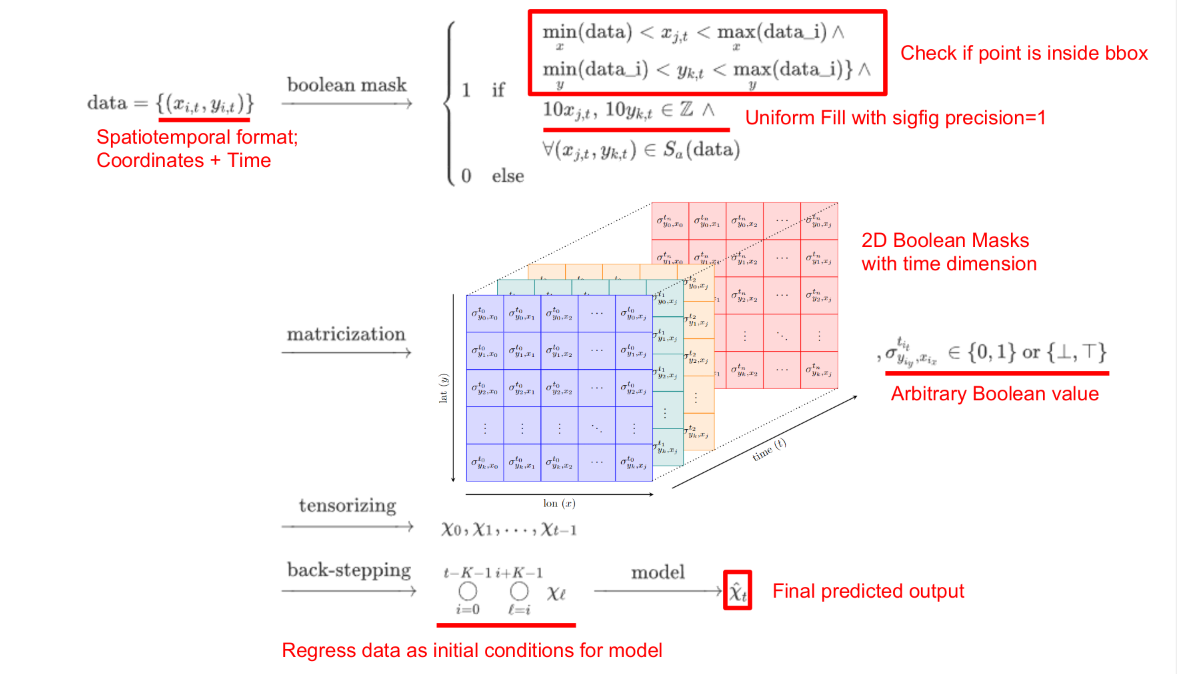

## Interpolated NOAA Report Data

### Stage 1: Generate Links
---
This stage prepares a list of links to be downloaded through the [DownThemAll!](https://chrome.google.com/webstore/detail/downthemall/nljkibfhlpcnanjgbnlnbjecgicbjkge) extension. The links are formatted as
$$
\overbrace{\text{https://www.spc.noaa.gov/climo/reports/}}^{\text{base url}}
\overbrace{\text{010411}}^{\text{date in YYMMDD}}
\overbrace{\text{_rpts_}}^{\text{reports}}
\overbrace{\text{torn}}^{\text{torn/hail/wind}}
\overbrace{\text{.csv}}^{\text{ext.}}
$$

The ```_parse_names()``` function generates a list of these urls over a range of 2004/5/27 (one of the first days with the correct NOAA links) to 2023/1/1 for every day and dumps it into a .txt file.

**Remark**: The old parse_names function takes a list of links from ```data.csv```, which was a truncated version of the event data spreadsheet. This interpretation has two fallbacks.
1.   Not enough data; produces torn, hail, and wind data at 36 datetimes
2.   Inconsistent frequency of data

For these reasons, ```_parse_names()``` is used instead of ```parse_names()```.



In [ ]:
import csv
# def parse_names():
#     with open("data.csv", "r") as f:
#         data = list(csv.reader(f, delimiter=","))

#     data = [i for i in data if i[1] == "Severe Storm"]
#     l = []
#     base = "https://www.spc.noaa.gov/climo/reports/"
#     suffixes = ["_rpts_torn.csv", "_rpts_wind.csv", "_rpts_hail.csv"]
#     for i in data:
#         # https://www.spc.noaa.gov/climo/reports/080428_rpts_torn.csv
#         parsed_date = i[0].split("/")
#         parsed_date = [parsed_date[2], a if len(a := parsed_date[0])==2 else "0"+a, b if len(b := parsed_date[1])==2 else "0"+b]
#         parsed_date = "".join(parsed_date)[2:]
#         for suf in suffixes:
#             l.append(base + parsed_date + suf)

#     print("\n".join(l))

# parse_names()

In [ ]:
import csv
import pandas as pd
from typing import List, Tuple, Dict

def _parse_names() -> None:
    data = pd.date_range(start="2004-05-27", freq="D", end="2023-01-01")
    data = list(data)
    data = [[str(sub_date.year)[2:], str(sub_date.month), str(sub_date.day)] for sub_date in data]

    base = "https://www.spc.noaa.gov/climo/reports/"
    l = []
    suffixes = ["_rpts_torn.csv", "_rpts_wind.csv", "_rpts_hail.csv"]
    for i in data:
        # https://www.spc.noaa.gov/climo/reports/080428_rpts_torn.csv
        parsed_date = [i[0], a if len(a := i[1])==2 else "0"+a, b if len(b := i[2])==2 else "0"+b]
        parsed_date = "".join(parsed_date)
        for suf in suffixes:
            l.append(base + parsed_date + suf)


    with open("urls.txt", "w", encoding="utf-8") as file:
        file.write("\n".join(l))

_parse_names()

### Stage 2: Loading downloaded data
---
By now, it is assumed that all the .csv files are downloaded into directory ```.\new_storm_data_csv\```. This stage simply consists of processing through each file (```os.listdir()```) with the function ```get_coords(_dir)```. All this data is stitched together into a dictionary, appropriately named ```data```.

For troubleshooting, ```get_coords``` has an additional parameter ```verbose=False``` which will print out extra info about a specified file, the example code for which is below the declaration for ```get_coords```. This was especially helpful for when NOAA had errors in their csv formatting, which created preventable complication.

In [ ]:
import csv
import os
import re
def get_coords(_dir: str, verbose: bool=False) -> List[Tuple[str, str]]:
    """
    Get a coordinate for a single file
    Inputs
    ------
    _dir: str
      Directory path for singular csv file
    verbose: bool
      Print extra data for troubleshooting
    """

        from tabulate import tabulate
        headers = "Time,F-Scale,Location,County,State,Lat,Lon,Comments".split(",")
        print(tabulate(data, headers, tablefmt="outline"))
        # [print(f"{(i[5])=}, {i[6]=}") for i in [l for l in data]]

    lat_c = []
    lon_c = []

    for i in data:
        # conditionals are to process NOAA's documentation errors
        if " " in i[5] or " " in i[6]:
            print("space instead of period: " + _dir)
        if i[6].replace(".", "").replace("-","").replace(" ", "").isdigit() and \
        i[5].replace(".", "").replace("-","").replace(" ", "").isdigit(): # correct
            lat_c.append(i[5].replace(" ", "."))
            lon_c.append(i[6].replace(" ", "."))
        elif i[5].isalpha() and len(i[5])==2: # check for split columns
            print("split columns: " + _dir)
            lat_c.append(i[6].replace(" ", "."))
            lon_c.append(i[7].replace(" ", "."))
        elif i[5] == "": # check for ?????
            print("double split columns: " + _dir)
            lat_c.append(i[6].replace(" ", "."))
            lon_c.append(i[7].replace(" ", "."))
        else: # else gives merged columns
            print("merged columns: " + _dir)
            lat_c.append(i[4].replace(" ", "."))
            lon_c.append(i[5].replace(" ", "."))


    return list(zip(lat_c, lon_c))

ind, sub_data = list(data.items())[16659]
print(ind)
res = get_coords(ind, verbose=True)
# get test flag
[(float(i[0]), float(i[1])) for i in res]

NameError: ignored

In [ ]:
def join_csvs() -> Dict[str, List[Tuple[str, str]]]:
    """
    Joins csv files into a unified dictionary

    Inputs
    ------
    None

    Returns
    -------
    Dict[str, List[Tuple[str, str]]]
      Keys are the directory path
      Values are a list of coordinate tuples
    """
    csvs = os.listdir("new_storm_data_csv")
    time_data = {}
    for ind in range(len(csvs)):
        # print(f"{csvs[ind]=}")
        # verbose_flag = csvs[ind]=="090626_rpts_torn.csv"
        sub_data = get_coords(csvs[ind])
        time_data[csvs[ind]] = sub_data

    return time_data

**Remark**:
<figure>
<center>
<img src='https://img001.prntscr.com/file/img001/CjRiT3kETiy1tMUQLYt1-w.png' />
<figcaption>merged columns</figcaption></center>
</figure>


<figure>
<center>
<img src='https://mail.google.com/mail/u/0?ui=2&ik=4b6d721605&attid=0.2&permmsgid=msg-a:r-911367613887835321&th=1896bb85b1149bd3&view=fimg&fur=ip&sz=s0-l75-ft&attbid=ANGjdJ--4uZ0hB-xmKcNyW0uFH_b3zyv6mi-YnRsdDUjCjtVGSG5ZA6G7BhG8ogg06t0Ak5APZBGz-rCXuIMKXno1Ea4HjGaXRP88AmS3C2C0YJ3IavTKKxB_adP_mc&disp=emb&realattid=ii_lk916ma91g' />
<figcaption>space instead of period</figcaption></center>
</figure>

<figure>
<center>
<img src='https://mail.google.com/mail/u/0?ui=2&ik=4b6d721605&attid=0.1&permmsgid=msg-a:r-6509021928195612748&th=1896bc5ed07eb392&view=fimg&fur=ip&sz=s0-l75-ft&attbid=ANGjdJ9a5HyLUZQxAXEFMWaF0FDxU_I3fThioSyIVxkiZBjSr2yFnYek_FDYI_cPBGw0_7ijXYeMAoY9AU7nv3_ktSJ02lgGrILWWWt6i1XU9GBvZvazkMYgOWOvFn4&disp=emb&realattid=ii_lk91qybp3' />
<figcaption>split columns</figcaption></center>
</figure>

<figure>
<center>
<img src='https://mail.google.com/mail/u/0?ui=2&ik=4b6d721605&attid=0.2&permmsgid=msg-a:r-8887406691147092341&th=189702ec15f09116&view=fimg&fur=ip&sz=s0-l75-ft&attbid=ANGjdJ8G_LM6vr0_f0hjcR-tXWF8wyXV0ZKfTB8jH_uwHxo5Q1XJ5LGqMIWyGq7dwBfqo5_tFlt-B7AbdD2V0xPL7QnNdezhU0GyTFpOBikcpcfkWbsyKYU3cMwrE5Y&disp=emb&realattid=ii_lka9p56o1' />
<figcaption>double split columns</figcaption></center>
</figure>

<figure>
<center>
<img src='https://mail.google.com/mail/u/0?ui=2&ik=4b6d721605&attid=0.3&permmsgid=msg-a:r-8887406691147092341&th=189702ec15f09116&view=fimg&fur=ip&sz=s0-l75-ft&attbid=ANGjdJ-4-cPTxjdvGEy9v6og_sB0xy4NoqcPgki1WZ8QiXuExMNwyzR4CdLVbIgGIb2cYHPuPfAyu7Q6Qf4sjlMuecJprT2Km8u3GuwOlgUTsFdQvS1yqrgxEBaftcA&disp=emb&realattid=ii_lka9tbfa2' />
<figcaption>out of us bbox</figcaption></center>
</figure>

In [ ]:
data = join_csvs()
data

FileNotFoundError: ignored

**Remark:**
```disgraced_indicies``` refers to the times when NOAA made mistakes with their lon/lat data, causing points to be outside the bounding box for the contiguous US. Although not having any consequence on the actual computations, it is worthy to point out for any future uses of the same data which may be affected by such discrepencies.

Commented out code contains an implementation which would remove ```disgraced_indicies``` from the input csvs.

In [ ]:
disgraced_indicies = {}
for ind, _data in list(data.items()):
    # _data = list of coords
    for sub_ind, event in enumerate(_data):
        # event = single coord
        ex, ey = float(event[0]), float(event[1])
        if -130 < ey < -60 and \
        20 < ex < 50:
            pass
        else:
            print(f"{ind} out of us bbox: {ex, ey} @ {sub_ind=}")
            disgraced_indicies[ind] = sub_ind

print(disgraced_indicies)

NameError: ignored

In [ ]:
# for file_name, ind in list(disgraced_indicies.items()):
#     print(file_name)
#     with open("new_storm_data_csv/"+file_name[:-4]+"_output.csv") as f:
#         data = list(csv.reader(f, delimiter=","))
#         del data[ind]

#         _data = np.array(data, dtype=float)
#         assert all(np.all(~np.logical_and([20, -130] <= _data, _data <= [50, -60]), axis=1))

#         with open("new_storm_data_output_csv/"+file_name[:-4]+"_output.csv", "w") as _f:
#             writer = csv.writer(_f, delimiter = ",")
#             for point in data:
#                 writer.writerow(point)

### Stage 3: Alphashape Computation
---
Stage 3 consists of computation needed to create a representation of the event data. It creates an alphashape which, in a sense, bounds the event data with representory polygons.
<figure>
<center>
<img src='https://i3.wp.com/i3.wp.com/i3.wp.com/img-blog.csdnimg.cn/2b2ae3ae51e74eabad7faf0dcbdbafee.png' />
<figcaption>An example of an alphashape with boundary discs</figcaption></center>
</figure>

The generated alphashape is then filled with a uniform filling of points. These points represent an approximation of where the event would be taking place over a precise area. The output of these interior points are dumped into a folder of csvs with directory ```.\new_storm_output_csvs\```.

In [ ]:
from shapely.ops import unary_union, polygonize
import shapely.geometry as geometry
from scipy.spatial import Delaunay
from shapely.geometry import Point
from matplotlib.collections import LineCollection
import matplotlib.pyplot as pl
from matplotlib.pyplot import *
import matplotlib.path as mpltPath
from descartes import PolygonPatch
import numpy as np
import math
import numba

def alpha_shape(coords: List[Tuple[float, float]],
                alpha: float) -> Tuple[geometry.Polygon | geometry.MultiPolygon |
                                       geometry.LineString | geometry.Point |
                                       geometry.GeometryCollection,
                                       List[Tuple[float, float]]]:
    """
    Generate alphashape; see https://arxiv.org/pdf/1505.00184.pdf

    Inputs
    ------
    coords: List[Tuple[float, float]]
      List of coordinate tuples

    alpha: float
      Alpha for alphashape

    Returns
    -------
    geometry.Polygon | geometry.MultiPolygon |
    geometry.LineString | geometry.Point |
    geometry.GeometryCollection
      A shapely.geometry representation of the alphashape

    List[Tuple[float, float]]
      Delaunay triangulation/voxels
    """
    if len(coords) < 4:
        points = [Point(i[1] , i[0]) for i in coords]
        return geometry.MultiPoint(list(points)).convex_hull

    # coords = np.array([point.coords[0] for point in points])
    tri = Delaunay(coords)
    triangles = coords[tri.vertices]
    a = ((triangles[:,0,0] - triangles[:,1,0]) ** 2 + (triangles[:,0,1] - triangles[:,1,1]) ** 2) ** 0.5
    b = ((triangles[:,1,0] - triangles[:,2,0]) ** 2 + (triangles[:,1,1] - triangles[:,2,1]) ** 2) ** 0.5
    c = ((triangles[:,2,0] - triangles[:,0,0]) ** 2 + (triangles[:,2,1] - triangles[:,0,1]) ** 2) ** 0.5
    s = ( a + b + c ) / 2.0
    areas = (s*(s-a)*(s-b)*(s-c)) ** 0.5
    circums = a * b * c / (4.0 * areas)
    filtered = triangles[circums < (1.0 / alpha)]
    edge1 = filtered[:,(0,1)]
    edge2 = filtered[:,(1,2)]
    edge3 = filtered[:,(2,0)]
    edge_points = np.unique(np.concatenate((edge1,edge2,edge3)), axis = 0).tolist()
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return unary_union(triangles), edge_points

ModuleNotFoundError: ignored

In [ ]:
import os
import csv
import shapely
def write_output(alpha: float) -> None:
    """
    Writes the output to a folder

    Parameters
    ----------
    alpha: float
      The alpha paramater for the alphashape

    Output
    ------
    Writes csv outputs to folder .\new_storm_data_output_csv\

    Returns
    -------
    None
    """
    for _ind in range(len(os.listdir("new_storm_data_csv"))):
        ind, sub_data = list(data.items())[_ind]
        print(f"{_ind=}")

        _sub_data = [Point(i[1] , i[0]) for i in sub_data]
        _sub_data = list(set(_sub_data))
        _sub_data = np.array([[i.x, i.y] for i in _sub_data])
        if not isinstance((a_shape := alpha_shape(_sub_data, alpha=alpha)), tuple):
            concave_hull = a_shape
        elif isinstance(a_shape, tuple):
            concave_hull, _ = a_shape
        else:
            raise Exception(f"Problem {a_shape}")

        sub_data = np.array(sub_data)

        N=100000
        lat = np.random.uniform(23,51,N)
        lon = np.random.uniform(-126,-64,N)
        uni_points = np.array([lon.ravel(), lat.ravel()]).T
        inside = np.empty([0, 2])

        if isinstance(concave_hull, geometry.Polygon):
            xx, yy = concave_hull.exterior.coords.xy
            xx, yy = np.array(xx), np.array(yy)
            _polygon = np.array([xx.ravel(), yy.ravel()]).T

            bbox = mpltPath.Path(_polygon)
            inside = uni_points[bbox.contains_points(uni_points)]

        elif isinstance(concave_hull, geometry.MultiPolygon):
            for polygon in concave_hull.geoms:
                xx, yy = polygon.exterior.coords.xy
                xx, yy = np.array(xx), np.array(yy)
                _polygon = np.array([xx.ravel(), yy.ravel()]).T

                bbox = mpltPath.Path(_polygon)
                _inside = uni_points[bbox.contains_points(uni_points)]
                inside = np.concatenate((inside, _inside))

        elif isinstance(concave_hull, geometry.LineString |
                        geometry.GeometryCollection |
                        geometry.Point):
            with open(f"new_storm_data_output_csv/{ind[:-4]}" + "_output" + ind[-4:], "w", encoding="utf-8", newline="") as _:
                continue
        else:
            raise Exception(f"Problem {concave_hull}")

        # output

        with open(f"new_storm_data_output_csv/{ind[:-4]}" + "_output" + ind[-4:], "w", encoding="utf-8", newline="") as file:
            print(len(inside))
            writer = csv.writer(file, delimiter = ",")
            for point in inside:
                writer.writerow(list(point))

# in safe mode so as to not overwrite previously generated data
__import__("sys").exit()
write_output(alpha=0.5)

### Stage 4: Verification
---
For the sake of verification, there are two cells completely dedicated to it. The first simply checks the number of files in ```.\new_storm_data_csvs\``` and ```.\new_storm_data_output_csvs\``` and makes sure that they are the same (i.e. insures bijectiveness). The second graphs each point onto a map of the US. For this to work, make sure there are [the neccesary shape files](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html) in the directory ```.\shapes\```,
although this implementation of a map can be changed pretty easily to a matplotlib basemap to skip this step.

In [ ]:
assert len(os.listdir("new_storm_data_csv/")) == len(os.listdir("new_storm_data_output_csv/"))

FileNotFoundError: ignored

In [ ]:
import geopandas as gpd
import contextily as ctx
import pandas as pd
import matplotlib.patches as patches

us = gpd.read_file("shapes/tl_2022_us_state.shp", crs="EPSG:4326")
for i in ['HI','VI','MP','GU','AK','AS','PR']:
    us = us[us.STUSPS != i]

fig = pl.figure(figsize=(30,30))
ax = fig.add_subplot()

ind, sub_data = list(data.items())[150]
_sub_data = [Point(i[1] , i[0]) for i in sub_data]
_sub_data = list(set(_sub_data))
__sub_data = np.array([[i.x, i.y] for i in _sub_data])
concave_hull, edge_points = alpha_shape(__sub_data, alpha=1.5)

pl.title(ind)
gdf = gpd.GeoDataFrame(_sub_data, geometry=_sub_data)
us.plot(ax=ax, cmap = "Wistia", edgecolor="white")
myPoly = gpd.GeoSeries([concave_hull])
myPoly.plot(ax=ax, facecolor="#c96502", edgecolor="#ffffff", label="Generated Alpha-Shape")
gdf.plot(ax=ax, marker='x', color='#000000', markersize=20, label="Inputted Data");
rect = patches.Rectangle((50, 50), 50, 50, linewidth=1, edgecolor='black', facecolor='#c96502', label="Generated Alpha-Shape")
ax.add_patch(rect)
pl.legend(loc ="lower left", prop={'size': 20})
pl.show()

ModuleNotFoundError: ignored

### Stage 5: Convert to Boolean mask
---
To preserve dimensionality, a boolean mask has to be created. Simplified, the steps are

1.   Compute bounding box
2.   Round every data point to the desired number of sigfigs and remove duplicates
3.   Find the difference between the bounding box edges and the coordinates
4.   Multiply by the number of sigfigs to get an integer index
5.   Repeat for every day
6.   Pickle to a BYTES format for ease of access.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate
import os
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
from shapely import geometry
import csv
import numpy as np
from typing import List, Tuple

def datetime_to_input(datetime: pd.Timestamp) -> int:
    """
    Finds the time between an initial date and a specified timestamp.
    This is to convert a intangible time to a tangible integer for input to the model

    Parameters
    ----------
    datetime: pd.Timestamp
      The timestamp representation of the date.
      This is not exclusive to pd.Timestamp and could be substituted easily.

    Returns
    -------
    int
      An integer representing the number of days between the initial and the specified
    """
    init = pd.to_datetime("2004-05-27")
    return int((datetime-init).days)

def gen_beebox(points: List[Tuple[float, float]]) -> List[Tuple[float, float]]:
    """
    Finds the global bbox of the data. The alternative name was generated by my uncoorperative brother, roger

    Parameters
    ----------
    points: List[Tuple[float, float]]
      A flattened list of coordinate tuples

    Retuns
    ------
    List[Tuple[float, float]] with len = 2
      A list of two coordinate tuples, corresponding to the upper left and the lower right
    """
    x_coordinates, y_coordinates = zip(*points)
    return [(min(x_coordinates), max(y_coordinates)), (max(x_coordinates), min(y_coordinates))]

def point_to_arr_index(point: Tuple[float, float], bee_box: List[Tuple[float, float]], sigfigs: int) -> Tuple[int, int]:
    """
    Calculates the array index given a coordinate. To do this, the upper left corresponds to index arr[0][0] and lower right [-1][-1].

    Note
    ----
    This function exponentially ties in sigfig percision. This is important to consider since every sigfig increase will increase the size of the final output by a factor of 10
    Additionally, the first index of the output maps to the second index of the empty array and vice versa.
    This is because the y-index corresponds with the first index since it gives the corresponding longitude array.

    Parameters
    ----------
    point: Tuple[float, float]
      A singular point
    bee_box: List[Tuple[float, float]] with len = 2
      Two points corresponding to the lower right and upper left coordinates
    sigfigs: int
      Significant figure percision

    Retuns
    ------
    Tuple[int, int]
      The index mapping to an empty array.
    """
    x_index = int(abs(point[0] - bee_box[0][0]) * 10**sigfigs)
    y_index = int(abs(point[1] - bee_box[0][1]) * 10**sigfigs)
    return (x_index, y_index)

In [ ]:
import os
assert os.path.exists("drive/MyDrive/new_storm_data_output_csv")

In [ ]:
import tensorflow as tf
import os
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
from shapely import geometry
import csv
import numpy as np
from itertools import groupby

def generate_input_data(sigfigs: int) -> None:
    """
    Generates input data for the model and pickles it

    Parameters
    ----------
    sigfigs: int
      Significant figure percision

    Outputs
    -------
    Tuple[List[int, List[List[int | bool]], List[List[int | bool]], List[List[int | bool]]]],
          List[int, List[List[int | bool]], List[List[int | bool]], List[List[int | bool]]]],
          List[List[List[int | bool]], List[List[int | bool]], List[List[int | bool]]]],
          List[List[List[int | bool]], List[List[int | bool]], List[List[int | bool]]]],
          int, int]
    A pickled tuple corresponding to (X_data_train, X_data_test, y_train, y_test, height, width)

    Returns
    -------
    None
    """
    initial_hail, initial_torn, initial_wind = [], [], []
    initial_inputs = []
    for subdir in os.listdir("drive/MyDrive/new_storm_data_output_csv"):
        with open("drive/MyDrive/new_storm_data_output_csv/"+subdir, "r") as file:
            interior = list(csv.reader(file, delimiter=","))
            interior = [[round(float(i[0]), sigfigs), round(float(i[1]), sigfigs)] for i in interior]
            interior = [k for k,v in groupby(sorted(interior))]

            ind = "20" + subdir
            ind = ind[:4] + "-" + ind[4:6] + "-" + ind[6:8]
            ind = datetime_to_input(pd.to_datetime(ind))

            initial_inputs.append((ind, interior))
            if "hail" in subdir:
                initial_hail.append((ind, interior))
            elif "torn" in subdir:
                initial_torn.append((ind, interior))
            elif "wind" in subdir:
                initial_wind.append((ind, interior))

    flattened_inputs = []
    for ind in range(len(initial_inputs)):
        for subind in range(len(initial_inputs[ind][1])):
            flattened_inputs.append(initial_inputs[ind][1][subind])

    bee_box = gen_beebox(flattened_inputs)
    height = int((abs(bee_box[0][1]-bee_box[1][1])) * 10**sigfigs)+1
    width = int((abs(bee_box[1][0]-bee_box[0][0])) * 10**sigfigs)+1
    print(height, width)

    subfinal_hail, subfinal_torn, subfinal_wind = [], [], []

    for day in initial_hail:
        # day = (date, [(x, y), (x, y),..., (x, y)])
        arr = np.zeros((height, width), dtype=np.float32)

        date, points = day[0], day[1]
        for point in points:
            point_arr = point_to_arr_index(point, bee_box, sigfigs)
            assert 0<=point_arr[0]<=width
            assert 0<=point_arr[1]<=height
            # the first index could potentially be a problem
            arr[height - point_arr[1]-1][point_arr[0]] = 1

        subfinal_hail.append((date, arr))

    for day in initial_torn:
        arr = np.zeros((height, width), dtype=np.float32)

        date, points = day[0], day[1]
        for point in points:
            point_arr = point_to_arr_index(point, bee_box, sigfigs)
            assert 0<=point_arr[0]<=width
            assert 0<=point_arr[1]<=height
            arr[height - point_arr[1]-1][point_arr[0]] = 1

        subfinal_torn.append((date, arr))

    for day in initial_wind:
        arr = np.zeros((height, width), dtype=np.float32)

        date, points = day[0], day[1]
        for point in points:
            point_arr = point_to_arr_index(point, bee_box, sigfigs)
            assert 0<=point_arr[0]<=width
            assert 0<=point_arr[1]<=height
            arr[height - point_arr[1]-1][point_arr[0]] = 1

        subfinal_wind.append((date, arr))

    final_hail, final_torn, final_wind = [], [], []
    final_hail_data = [(subfinal_hail[ind][1], subfinal_hail[ind+1][1], subfinal_hail[ind+2][1]) \
         for ind in range(len(subfinal_hail)-2)]

    final_torn_data = [(subfinal_torn[ind][1], subfinal_torn[ind+1][1], subfinal_torn[ind+2][1]) \
         for ind in range(len(subfinal_torn)-2)]

    final_wind_data = [(subfinal_wind[ind][1], subfinal_wind[ind+1][1], subfinal_wind[ind+2][1]) \
         for ind in range(len(subfinal_wind)-2)]

    final_hail_outputs = [
        subfinal_hail[ind][1] for ind in range(2, len(subfinal_hail))
    ]
    final_torn_outputs = [
        subfinal_torn[ind][1] for ind in range(2, len(subfinal_torn))
    ]
    final_wind_outputs = [
        subfinal_wind[ind][1] for ind in range(2, len(subfinal_wind))
    ]

    final_input_dates = [subfinal_hail[ind][0] for ind in range(2, len(subfinal_hail))]

    # combine into one input list of four-tuples
    final_inputs = []
    for i in range(0, len(subfinal_hail) - 2):
        final_inputs.append((final_input_dates[i], final_hail_data[i], final_torn_data[i], final_wind_data[i]))

    final_outputs = []
    for i in range(0, len(subfinal_hail) - 2):
        final_outputs.append((final_hail_outputs[i], final_torn_outputs[i], final_wind_outputs[i]))

    X_data_train, X_data_test, y_train, y_test = train_test_split(final_inputs, final_outputs, test_size=0.2) # shuffle=False off obv
    # X_date_train, X_date_test,_,_ = train_test_split(final_inputs, np.zeros(len(final_inputs)).tolist(), test_size=0.2, shuffle=False)
    with open("drive/MyDrive/precomp_inputs.BYTES", "wb") as f:
        pickle.dump((X_data_train, X_data_test, y_train, y_test, height, width), f)

generate_input_data(sigfigs=1)

**Remark**: Note that the filter size makes it so that the hidden resizing done afterwards preserves as much data as possible.

**Remark**: Following rudimentary predictions made after the first batch of training, a problem was discovered with the ```Embedding``` layer which made it impossible to use. As the [Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding?hl=en#:~:text=Integer.%20Size%20of%20the%20vocabulary%2C%20i.e.%20maximum%20integer%20index%20%2B%201.) states, the input dimension of the ```Embedding``` layer must be the vocabulary size. In this case, the vocabulary is equivalent to the number of datapoints or days in the training dataset, or numerically, $20,382$. Since the number of training params is directly proportional to the input dim, it is infeasible to do let the input dim be the untruncated training data. With this in mind, a new approach was needed, and after consideration, there were three possible solutions, the ones which were chosen highlighted in green:

<font size=5>*Date Preprocessing*</font>
1.   <font color=lightgreen>Modulus</font>; keep ```input_dim=365``` but preprocess the input,
> ```python
>days_input = ...
>days_input_modulo = days_input % 365
>Embedding(input_dim=365, ...)
> ```

  or alternatively, use a ```divmod```-like solution (this implementation can easily be made to do element-wise multiplication or some other form of merging if necessary),
>```python
>quotient, remainder = tf.math.floordiv(days_input, 365), tf.math.mod(days_input, 365)
>embedded_remainder = Embedding(input_dim=365, output_dim=embedding_dim, name='embedded_days')(remainder)
>quotient_rescaled = tf.keras.layers.Rescaling(scale=1./365)(quotient)
>combined = tf.keras.layers.Concatenate()([embedded_remainder, tf.expand_dims(quotient_rescaled, -1)])
>```

  The current implementation is
  $$\text{scale} = \text{days_input} \cdot \left(0.1 + \dfrac{\text{remainder}}{365}\right) \cdot \text{quotient}$$

  and multiplying by every
2.  <font color=red>~~Trig Normalization~~</font>; do a simple trigonometric normalization from $[0, +\infty)\mapsto[-1, 1]$, like so

  $$
\begin{align*}
\text{days_input_sin} &= \sin\left(\dfrac{2\pi\cdot\text{days_input}}{365}\right) \\[0.5em]
\text{days_input_cos} &= \cos\left(\dfrac{2\pi\cdot\text{days_input}}{365}\right)
\end{align*}
$$
  or in code,
> ```python
> days_input_sin = tf.math.sin(2 * np.pi * days_input / 365)
> days_input_cos = tf.math.cos(2 * np.pi * days_input / 365).
>```

  Note that this implementation has both $\sin$ and $\cos$. This is to preserve reversibility, since there are two solutions to $\sin x = k$ for $|k|<1$ depending on which hemisphere the inner value lies on. Also note that zeros can be prevented in this process by simply changing some of the parameters if necessary to ensure that zero never occurs, like off-setting the denominator by a small number or adding some number to the end of the trig computation. This implementation can also be extended to account for time in years. For example, a rough addition would be to multiply the ```tf.math.floordiv``` to the end of the computation.

  This is, by far, the most widely used implementation of normalizing dates, since it captures the cyclical nature of time like a modulus would while also normalizing at the same time.

  *ERRATA*: doing this ensured a doubing of computation needed, and is especially problematic otherwise since support for complex operations is lacking.

3.  Linear Normalization; linearly normalize modulo to $[0, 365]\mapsto[-1, 1]$, like so

  $$\text{days_input_normalized} = \dfrac{\text{days_input}\pmod{365}}{182.5}-1$$
  or in code,

  > ```python
  > days_input_remainder = tf.math.mod(days_input, 365)
  > days_input_normalized = (days_input_remainder / 182.5) - 1
  >```

  Everything in the trig normalization implementations stands here, except for this being the most widely used implementation.

<font size=5>*Merging Data*</font>
(Getting both the LSTM data and the embed/normalized days to merge into one).


1.   Concatenation; simply concatenating the two tensors. Doing this, while simple, is unsophisticated -- it leads to messy output data and overall struggles picking up on the nuanced relationship between the input data and the date. Additionally, doing this leads to the need to downsample the data by a factor of 4 since they need to be of equal shape to concatenate. There are two main downsampling algorithms which can be used to do this which also can be trained,
    * Simple Convolution (old impl.); Do a 3x3 2D convolution over the data to reduce it from $(h, w, 6)\mapsto(h, w, 3)$.
    * Dense Layer. This solution, while possible, is computationally intensive and cannot pick up on spatial patterns like convolutions can. Thus, this makes Dense layers less effective than convolutions at downsampling.
2.   Element-wise Operations; the downsides to these are that they need to have the same shape, although concatenation has the same downside. There are two element-wise operations which can be applied to both tensors when they are the same shapes:
    * <font color=lightgreen>Multiplication</font>; multiplication is generally more effective than addition since it allows for more complex interactions between the feature sets. Unlike concatenation, it does not change the shape.
    * Addition; like multiplication, it does not change the shape. Other than this, there is nothing more that can meaningfully be said about addition other than its existence.

<font size=5>*Merging Position*</font>
1.    <font color=lightgreen>Before LSTM</font>; this ensures that the date is processed along with the raw data into the ConvLSTM2D cells. This will allow for more complex interactions between the day and the event data.
2.    After LSTM; this processes the data after the ConvLSTM2D cells, which retains the raw event data's predicted structure but does not allow for complex interactions between the day and the event data. This implementation is, however, slightly easier to adapt to extended models.

**Remark**: Using a unified ConvLSTM with 3 features seems to cause the output to look like the same bounding shape, with only the confidence levels varying <figure>
<center>
<img src="https://i.ibb.co/85zhv8P/asdasdasdasdasd.png" />
<figcaption>An example of similar output shapes, which are on the right of the image. This output was generated by the first iteration of the model. Because of rendering issues, some of the things do not show up on the figure, which causes the annoying negative vspace between the input and output diagrams.</figcaption></center>
</figure>

Despite the absurdly high accuracy of the storm and wind input, the abysmal hail accuracy prompts improvement in the model. To try to combat the similar shapes, a "*tripartite*" can be constructed from ConvLSTM's, each consisting of one feature corresponding to each input.

## Meteorological NetCDF/GRIB Data
<figure>
<center>
<img src='https://i.ibb.co/j6kPBGF/mermaid-diagram-2023-08-16-150951.png' />
<figcaption>Link: <a href=https://i.ibb.co/j6kPBGF/mermaid-diagram-2023-08-16-150951.png>https://i.ibb.co/j6kPBGF/mermaid-diagram-2023-08-16-150951.png</a></figcaption></center>
</figure>


The following code is rather self-explanatory

In [ ]:
# [(-124.2, 49.3), (-67.1, 24.5)]
import os
import xarray as xr
from scipy.signal import convolve2d
from datetime import datetime, timedelta
from calendar import isleap
import numpy as np
from tensorflow import TensorSpec, float32
from tensorflow.data import Dataset
def data_gen(test=False):
    base = "lst_data_nc/"
    years = [str(i) for i in range(2004, 2022+1)]
    data_types = ("pr", "th", "vs")
    expanded_mapping = {
        "pr": "precipitation_amount",
        "th": "wind_from_direction",
        "vs": "wind_speed"
    }
    for year in years:
        if year == "2004":
            # 040527
            days = [datetime(int(year), 5, 27) + timedelta(days=i) \
                    for i in range(0, 219)]
        else:
            days = [datetime(int(year), 1, 1) + timedelta(days=i) \
                    for i in range(0, 365+isleap(int(year)))]

        for day in days:
            _dict = {}
            if not test: print(f"{year=} | {day=}")
            for data_type in data_types:
                _dir = f"{base}{data_type}_nc/{data_type}_{year}.nc"
                ds = xr.open_dataset(_dir) # './lst_data_nc/pr_nc/pr_2004.nc'
                if test:
                    key = expanded_mapping[data_type]

                    # [(-124.2, 49.3), (-67.1, 24.5)]
                    # upper left       lower right
                    lat_min, lat_max = 49.3, 24.5; lon_min, lon_max = -124.2, -67.1
                    ds_trimmed = ds.sel(lat=slice(lat_min, lat_max), \
                                        lon=slice(lon_min, lon_max), \
                                        day=datetime(2004, 5, 27))

                    new_lat = np.linspace(lat_max, lat_min, int((lat_min-lat_max)/0.1) + 1)
                    new_lon = np.linspace(lon_min, lon_max, int((lon_max-lon_min)/0.1) + 1)
                    ds_interp = ds_trimmed.interp(lat=new_lat, lon=new_lon, method="nearest")

                    kernel_size = int(2.4) # approx
                    kernel = np.ones((kernel_size-1, kernel_size-1)) / (kernel_size * kernel_size)

                    precip_data = ds_interp[key].values
                    convoluted_data = convolve2d(precip_data, kernel, mode='valid', boundary='wrap')
                    ds_interp[key].values = convoluted_data

                    ds_interp['lat'] = new_lat; ds_interp['lon'] = new_lon

                    _dict[data_type] = ds_interp; _dict[data_type+"_"] = xr.open_dataset(_dir).sel(day=day)

                else:
                    key = expanded_mapping[data_type]

                    # [(-124.2, 49.3), (-67.1, 24.5)]
                    # upper left       lower right
                    lat_min, lat_max = 49.3, 24.5; lon_min, lon_max = -124.2, -67.1
                    ds_trimmed = ds.sel(lat=slice(lat_min, lat_max), \
                                        lon=slice(lon_min, lon_max), \
                                        day=day)

                    new_lat = np.linspace(lat_max, lat_min, int((lat_min-lat_max)/0.1) + 1)
                    new_lon = np.linspace(lon_min, lon_max, int((lon_max-lon_min)/0.1) + 1)

                    ds_interp = ds_trimmed.interp(lat=new_lat, lon=new_lon, method="nearest")

                    kernel_size = int(2.4) # approx
                    kernel = np.ones((kernel_size-1, kernel_size-1)) / (kernel_size * kernel_size)

                    precip_data = ds_interp[key].values
                    convoluted_data = convolve2d(precip_data, kernel, mode='valid', boundary='wrap')
                    convoluted_data[np.isnan(convoluted_data)] = 0

                    _dict[data_type] = convoluted_data

            yield _dict

height, width = 248, 572
spec = {
        "pr": TensorSpec(shape=(height, width), dtype=float32),
        "th": TensorSpec(shape=(height, width), dtype=float32),
        "vs": TensorSpec(shape=(height, width), dtype=float32)
    }
data = Dataset.from_generator(data_gen, output_signature=spec)

In [ ]:
import shutil
shutil.rmtree('nc_model_input')
data.save(path="nc_model_input", compression="GZIP")

# The Model
---


## Model Declarations
---
This section includes all the various model implementations used in trying to predict/detect reports. They go as follows
1. **The Unified Implementation**
$$
\begin{array}{|c|c|c|c|c|}
\hline
\text{Inputs} & \text{Data Source} & \text{Merging Op.} & \text{Output} & \text{Main Comp.} \\
\hline
\mathcal{X}: (3, h, w) ~\text{torn} & \text{Alphashape} & \text{feat. Concatenation} & \hat{\mathcal{X}}: (h, w) ~\text{torn}\\
\mathcal{Y}: (3, h, w) ~\text{hail} & \text{of NOAA} & \text{time Multiplication} & \hat{\mathcal{Y}}: (h, w) ~\text{hail} & \text{ConvLSTM2D}\\
\mathcal{Z}: (3, h, w) ~\text{wind} & \text{reports} & & \hat{\mathcal{Z}}: (h, w) ~\text{wind}\\
\hline
\end{array}
$$


2. **Tripartite Implementation**
$$
\begin{array}{|c|c|c|c|c|}
\hline
\text{Inputs} & \text{Data Source} & \text{Merging Op.} & \text{Output (sep.)} & \text{Main Comp.} \\
\hline
\mathcal{X}: (3, h, w) ~\text{torn} & \text{Alphashape} & \text{feat. Trainable Addition} & \hat{\mathcal{X}}: (h, w) ~\text{torn}\\
\mathcal{Y}: (3, h, w) ~\text{hail} & \text{of NOAA} & \text{time Multiplication} & \hat{\mathcal{Y}}: (h, w) ~\text{hail} & \text{ConvLSTM2D}\\
\mathcal{Z}: (3, h, w) ~\text{wind} & \text{reports} & & \hat{\mathcal{Z}}: (h, w) ~\text{wind}\\
\hline
\end{array}
$$


3. **Detection Model**
$$
\begin{array}{|c|c|c|c|c|}
\hline
\text{Inputs} & \text{Data Source} & \text{Merging Op.} & \text{Output (sep.)} & \text{Main Comp.} \\
\hline
\mathcal{X}: (h, w) ~\text{pr} & \text{Alphashape of NOAA reports} & \text{feat. Wei, Ye, et. al.} & \hat{\mathcal{X}}: (h, w) ~\text{torn}\\
\mathcal{Y}: (h, w) ~\text{th} & \text{+} & \text{time Multiplication} & \hat{\mathcal{Y}}: (h, w) ~\text{hail} & \text{U-Net}\\
\mathcal{Z}: (h, w) ~\text{vs} & \text{Northwest Knowladge Metadata} & & \hat{\mathcal{Z}}: (h, w) ~\text{wind}\\
\hline
\end{array}
$$

### Model 1: Unified Implementation
---
The model can be explained through a flowchart succinctly: \\
<font size=2>(NB: there is an updated codebase which, while being less updated on model compilation and training, is more updated on future data processing and extended model architecture)
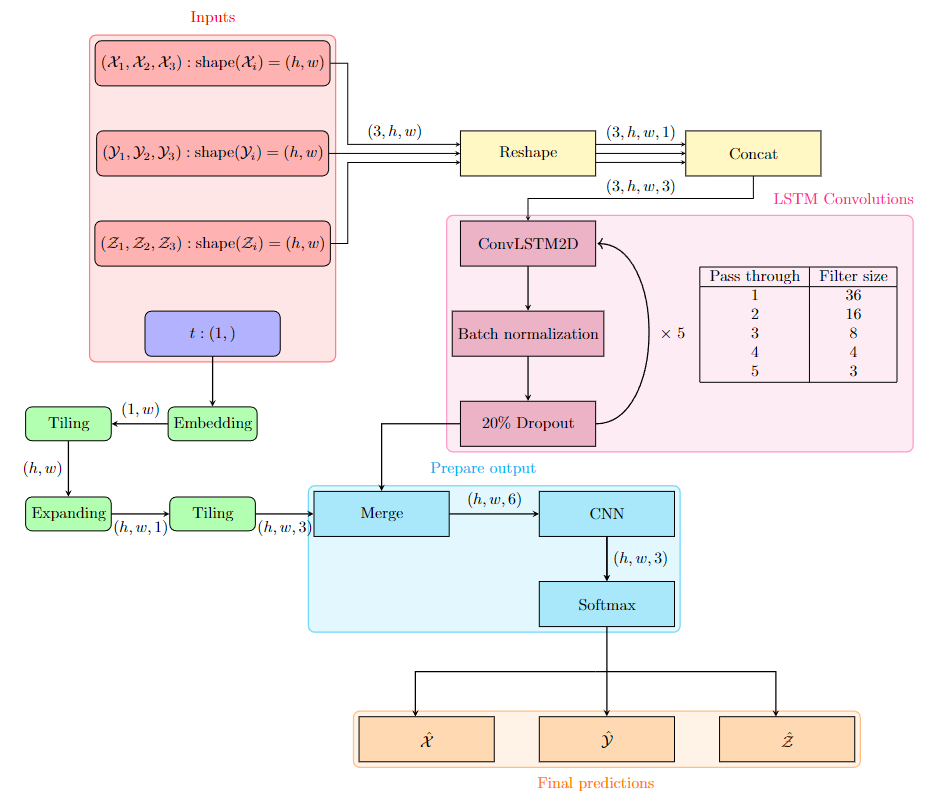

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Reshape, \
    Embedding, Concatenate, Flatten, LSTM, Dense, \
    UpSampling2D, Conv2D, Conv2DTranspose, Lambda, \
    ConvLSTM2D, Dropout, Softmax, RepeatVector, Dot, \
    BatchNormalization

def create_model(height: int, width: int, batch_size: int):
    # ============
    # Inputs
    # ============
    days_input_shape = (1,)
    storm_input_shape = (3, height, width) # height = 2411, width = 4911
    hail_input_shape = (3, height, width)
    wind_input_shape = (3, height, width)

    days_input = keras.layers.Input(shape=days_input_shape, batch_size=batch_size, name='days_input', dtype=tf.float32)
    storm_input = keras.layers.Input(shape=storm_input_shape, batch_size=batch_size, name='storm_input', dtype=tf.float32)
    hail_input = keras.layers.Input(shape=hail_input_shape, batch_size=batch_size, name='hail_input', dtype=tf.float32)
    wind_input = keras.layers.Input(shape=wind_input_shape, batch_size=batch_size, name='wind_input', dtype=tf.float32)

    # ============
    # Tessellation
    # ============
    quotient, remainder = tf.math.floordiv(days_input, 365), tf.math.mod(days_input, 365)
    scale = days_input * (0.1 + remainder/365) * quotient
    scale = Reshape((1, 1, 1 ,1))(scale)

    # =======================
    # Convolutional 2D LSTM
    # =======================
    storm_input_reshaped = Reshape((3, height, width, 1), name="storm_input_reshaped")(storm_input)
    hail_input_reshaped = Reshape((3, height, width, 1), name="hail_input_reshaped")(hail_input)
    wind_input_reshaped = Reshape((3, height, width, 1), name="wind_input_reshaped")(wind_input)

    storm_input_reshaped *= scale
    hail_input_reshaped *= scale
    wind_input_reshaped *= scale

    conv_lstm_storm_1 = ConvLSTM2D(filters=1, kernel_size=(5, 5), \
                             padding='same', name="conv_lstm_storm_1", return_sequences=True) \
                                  (storm_input_reshaped)
    conv_lstm_norm_storm_1 = BatchNormalization()(conv_lstm_storm_1)
    conv_lstm_drop_storm_1 = Dropout(0.2, name="conv_lstm_drop_storm_1")(conv_lstm_norm_storm_1)

    conv_lstm_storm_2 = ConvLSTM2D(filters=2, kernel_size=(4, 4), \
                             padding='same', name="conv_lstm_storm_2", return_sequences=True) \
                                  (conv_lstm_drop_storm_1)
    conv_lstm_norm_storm_2 = BatchNormalization()(conv_lstm_storm_2)
    conv_lstm_drop_storm_2 = Dropout(0.2, name="conv_lstm_drop_storm_2")(conv_lstm_norm_storm_2)

    conv_final_storm_output = ConvLSTM2D(filters=2, kernel_size=(3, 3), \
                             padding='same', name="conv_final_storm_output") \
                                        (conv_lstm_drop_storm_2)
    # =========================================================================================
    conv_lstm_wind_1 = ConvLSTM2D(filters=1, kernel_size=(5, 5), \
                             padding='same', name="conv_lstm_wind_1", return_sequences=True) \
                                  (wind_input_reshaped)
    conv_lstm_norm_wind_1 = BatchNormalization()(conv_lstm_wind_1)
    conv_lstm_drop_wind_1 = Dropout(0.2, name="conv_lstm_drop_wind_1")(conv_lstm_norm_wind_1)

    conv_lstm_wind_2 = ConvLSTM2D(filters=2, kernel_size=(4, 4), \
                             padding='same', name="conv_lstm_wind_2", return_sequences=True) \
                                  (conv_lstm_drop_wind_1)
    conv_lstm_norm_wind_2 = BatchNormalization()(conv_lstm_wind_2)
    conv_lstm_drop_wind_2 = Dropout(0.2, name="conv_lstm_drop_wind_2")(conv_lstm_norm_wind_2)

    conv_final_wind_output = ConvLSTM2D(filters=2, kernel_size=(3, 3), \
                             padding='same', name="conv_final_wind_output") \
                                        (conv_lstm_drop_wind_2)
    # =========================================================================================
    conv_lstm_hail_1 = ConvLSTM2D(filters=1, kernel_size=(5, 5), \
                             padding='same', name="conv_lstm_hail_1", return_sequences=True) \
                                  (hail_input_reshaped)
    conv_lstm_norm_hail_1 = BatchNormalization()(conv_lstm_hail_1)
    conv_lstm_drop_hail_1 = Dropout(0.2, name="conv_lstm_drop_hail_1")(conv_lstm_norm_hail_1)

    conv_lstm_hail_2 = ConvLSTM2D(filters=2, kernel_size=(4, 4), \
                             padding='same', name="conv_lstm_hail_2", return_sequences=True) \
                                  (conv_lstm_drop_hail_1)
    conv_lstm_norm_hail_2 = BatchNormalization()(conv_lstm_hail_2)
    conv_lstm_drop_hail_2 = Dropout(0.2, name="conv_lstm_drop_hail_2")(conv_lstm_norm_hail_2)

    conv_final_hail_output = ConvLSTM2D(filters=2, kernel_size=(3, 3), \
                             padding='same', name="conv_final_hail_output") \
                                        (conv_lstm_drop_hail_2)

    # ============
    # Output
    # ============
    storm_output = Softmax()(conv_final_storm_output)
    hail_output = Softmax()(conv_final_hail_output)
    wind_output = Softmax()(conv_final_wind_output)

    model = tf.keras.Model(
        inputs=[days_input, storm_input, hail_input, wind_input],
        outputs=[storm_output, hail_output, wind_output],
        name="ClimatePredictionModel"
    )
    return model

### Model 2: Tripartite Implementation
---
This implementation differs from the unified one by splitting each input component into its own model (hence tripartite). To ensure maximum accuracy, each model still gets every input, but unlike before, they are weighted to support more complex interactions. Using custom model variables, the model can train these weights with initializations based on the normal distribution
$$\mathcal{N}(0.2, 10)=\dfrac1{10\sqrt{2\pi}}e^{-\tfrac1{200}(x-0.2)^2}.$$

The weighting is done by effectively transforming the range wherein the boolean data lies. A general implementation would be WLOG letting $\mathcal{X}$ be the main input tensor (the value to be predicted) and $\mathcal{Y}, \mathcal{Z}$ be the other input tensors. Performing a simple mapping (AKA a *change of basis*), we can transform the ranges as such
$$
\begin{array}{c|c|c}
\mathcal{X}&\mathcal{Y}&\mathcal{Z} \\\hline
\{0, 1\}\overset{I}{\longmapsto}\{0, 1\} & \{0, 1\}\overset{w_1(x-0.5)}{\longmapsto}\{-0.5w_1, 0.5w_1\} & \{0, 1\}\overset{w_2(x-0.5)}{\longmapsto}\{-0.5w_2, 0.5w_2\} \\
\mathrm{(base)}
\end{array}
$$

where $w_1, w_2$ are the weights, which will be learned by the model. The addition of variable weights gives the model additional complexity and allows for inhomogenous relationships between the three datasets, theoretically bolstering accuracy.

Intuitively, this "*weighting*" process can be thought of as assigning correspondence factors between the primary and secondary event types, where a low correspondence is reflected by a low weight and vice versa. This correspondence is reflected in the final merging operation through the equation
$$\mathcal{X}_{\mathrm{weighted}} = \mathcal{X} + (\mathcal{Y}-0.5)\cdot w_1 + (\mathcal{Z}-0.5)\cdot w_2.$$

Additionally, increasing the weight would graphically correspond to enlargened 1D range. Here's an example for when $w_2 < w_1$:

<center>
<img src="https://img001.prntscr.com/file/img001/-0WgIGjPQbu3PjykUce14Q.png" />
</center>

Another change from the previous model (which can, admittedly, be simply substituted into Model 1) is the addition of binary cross entropy. Similarly to categorical cross entropy, binary cross entropy weights probability losses logorithmically. However, unlike categorical, binary assumes that there is only one data category. Thus, it only needs one pass through of the initial output, and can uniquely be optimized for binary datasets. The general formula for binary cross entropy provided by Tensorflow's ```tf.keras.losses.BinaryCrossentropy``` function is
$$\text{H}(\hat{\mathbf{y}}, \mathbf{y}) = -\dfrac1N \sum_i^Ny_i\log \hat{y_i} + (1-y_i)\log(1-\hat{y_i})$$

where $\hat{\mathbf{y}}$ and $\mathbf{y}$ are the predicted and true tensors. Note the difference from the categorical cross entropy function
$$\text{H}(\hat{\mathbf{y}}, \mathbf{y}) = -\dfrac1N\sum_{i=1}^N\sum_{c=1}^C \mathbf{1}_{y_i\in C_c}\log[\hat{y}_i\in C_c]$$

where there is a passthrough of every category and a noticeably different structure inside the sum.

After fixing all problems related to actually runing the model, there is a problem which can be added rather easily in the merging layer. When it comes to correlations, they aren't necessarily symmetrical in the sense that the negation of something may not have the same negative impact as positive with the existence of it.

Thus, in the case when there is an asymmetrical correlation, two weights can be added for the positive and negative sides of the boolean values,
$$\mathcal{X}_{\mathrm{weighted}} = \mathcal{X} + \dfrac12\mathcal{Y}\cdot w_{y, 1}w_{y, 2} + \dfrac12\mathcal{Z}\cdot w_{z, 1}w_{z, 2} \\w_{y, 1}, w_{z, 1}\in[0, 1.5] , w_{y, 2}, w_{z, 2}\in[-1, 1].$$

**Remark**: ~due to how Tensorflow works--specifically on how it deals with custom layers--there can arise certain compatibility issues which have to be avoided deftly. The following code is purely for troubleshooting these issues.~

~*NB*: most issues tend to arise in the form of an obscure error message; specifically,~
> <pre><code lang=python>ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.
</code></pre>

(ignore!)

**Remark**: The structure of TensorFlow occasionally makes debugging complicated because TensorFlow often returns limited information about the nature of errors. This was dealt with through lots of guesswork and trial/error. For personal reference, here are a list of common errors encountered while running the model:
*   Incompatible layer inputs and outputs
*   Incompatible loss function
*   Incompatible optimizer (?)
*   NaN's
*   Callbacks
*   Old Tensorflow versions
*   Custom layer problems



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Reshape, \
    Embedding, Concatenate, Flatten, LSTM, Dense, \
    UpSampling2D, Conv2D, Conv2DTranspose, Lambda, \
    ConvLSTM2D, Dropout, Softmax, RepeatVector, Dot, \
    BatchNormalization, Conv3D, Activation
from tensorflow.keras.initializers import GlorotNormal

def create_Conv2DLSTM_unit(input_tensor, filter_size: int, n: int, kernel_size, return_sequences=True):
    locals()[f"conv_lstm_{n}"] = ConvLSTM2D(filters=filter_size, kernel_size=kernel_size, \
                                            padding='same', name=f"conv_lstm_{n}", \
                                            return_sequences=return_sequences, \
                                            kernel_initializer=GlorotNormal(), \
                                            data_format="channels_last") \
                                 (input_tensor)

    locals()[f"conv_lstm_norm_{n}"] = BatchNormalization(name=f"conv_lstm_norm_{n}") \
                                      (locals()[f"conv_lstm_{n}"])

    locals()[f"conv_lstm_drop_{n}"] = Dropout(0.2, name=f"conv_lstm_drop_{n}") \
                                      (locals()[f"conv_lstm_norm_{n}"])

    return locals()[f"conv_lstm_drop_{n}"]

def create_Conv2DLSTM_sequential(input_tensor):
    # conv_lstm_1 = create_Conv2DLSTM_unit(input_tensor, 6, 1, (6, 6))
    # print(f"{conv_lstm_1=}")

    conv_lstm_1 = create_Conv2DLSTM_unit(input_tensor, 1, 1, (5, 5))

    conv_lstm_2 = create_Conv2DLSTM_unit(conv_lstm_1, 2, 2, (4, 4))

    conv_lstm_3 = create_Conv2DLSTM_unit(conv_lstm_2, 3, 3, (3, 3))

    conv_lstm_4 = create_Conv2DLSTM_unit(conv_lstm_3, 4, 4, (2, 2))

    conv_lstm_output = create_Conv2DLSTM_unit(conv_lstm_4, 1, "final", (1, 1), \
                                              return_sequences=False)

    return conv_lstm_output

class MergeLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # note: initializer repeated -> equal weight initializations
        self.initializer_1 = tf.keras.initializers.RandomNormal(
            mean=0.2, stddev=0.1, seed=None
        )
        self.initializer_2 = tf.keras.initializers.RandomNormal(
            mean=0.2, stddev=0.1, seed=None
        )
        self.weight_constraint = lambda w: tf.clip_by_value(w, 0, 3)

    def build(self, input_shape):
        self.w_1 = self.add_weight(name="w_1", shape=(), trainable=True, \
                                 initializer=self.initializer_1, constraint=self.weight_constraint, \
                                 regularizer=tf.keras.regularizers.l2(0.01))
        self.w_2 = self.add_weight(name="w_2", shape=(), trainable=True, \
                                 initializer=self.initializer_2, constraint=self.weight_constraint, \
                                 regularizer=tf.keras.regularizers.l2(0.01))

    def call(self, inputs):
        return tf.cast(inputs[0], tf.float32) + \
        (tf.cast(inputs[1], tf.float32)-.5)*self.w_1 + \
        (tf.cast(inputs[2], tf.float32)-.5)*self.w_2

In [ ]:
def create_model(height: int, width: int, batch_size: int):
    # ============
    # Inputs
    # ============
    days_input_shape = ()
    storm_input_shape = (3, height, width)
    hail_input_shape = (3, height, width)
    wind_input_shape = (3, height, width)

    days_input = keras.layers.Input(shape=days_input_shape, batch_size=batch_size, name='days_input', dtype=tf.float32)
    storm_input = keras.layers.Input(shape=storm_input_shape, batch_size=batch_size, name='storm_input', dtype=tf.float32)
    hail_input = keras.layers.Input(shape=hail_input_shape, batch_size=batch_size, name='hail_input', dtype=tf.float32)
    wind_input = keras.layers.Input(shape=wind_input_shape, batch_size=batch_size, name='wind_input', dtype=tf.float32)

    # ============
    # Tessellation
    # ============
    quotient, remainder = tf.math.floordiv(days_input, 365), tf.math.mod(days_input, 365)
    scale = days_input * (0.1 + remainder/365) * quotient
    scale_reshaped = Reshape((1, 1, 1 ,1), name="scale_reshaped")(scale)

    # =======================
    # Merging Operation
    # =======================
    merged_inputs = MergeLayer(name="merged_inputs")([storm_input, hail_input, wind_input])

    merged_inputs_reshaped = Reshape((3, height, width, 1), name="merged_inputs_reshaped") \
                             (merged_inputs)

    merged_inputs_reshaped *= scale_reshaped

    # =======================
    # ConvLSTMs
    # =======================
    conv_lstm_output = create_Conv2DLSTM_sequential(merged_inputs_reshaped)
    conv_lstm_reshape = Reshape((height, width), name="conv_lstm_reshape")(conv_lstm_output)
    output = Activation("sigmoid", name="sigmoid_output")(conv_lstm_reshape)

    # reshaped_conv_lstm_output = Conv3D(filters=1, kernel_size=(2, 2, 2), \
    #                                    activation="sigmoid", padding="same", \
    #                                    data_format="channels_last") \
    #                                   (conv_lstm_output)
    #
    # conv_lstm_output_prob = Softmax(name="conv_lstm_output_prob")(conv_lstm_output)

    # =======================
    # Output
    # =======================
    model = tf.keras.Model(
        inputs=[days_input, storm_input, hail_input, wind_input],
        outputs=output,
        name="ClimatePredictionModel"
    )

    return model

In [ ]:
import numpy as np
torn = 1 * (np.random.rand(10, 20) > 0.5)
torn = np.array((torn, torn, torn))
hail = 1 * (np.random.rand(10, 20) > 0.5)
hail = np.array((hail, hail, hail))
wind = 1 * (np.random.rand(10, 20) > 0.5)
wind = np.array((wind, wind, wind))
MergeLayer()([torn, hail, wind])

### Model 3: Detection Model
---

**Grapical Abstract**
<figure>
<center>
<img src='https://img001.prntscr.com/file/img001/Nzin7swzTl-aLydk5B3bpQ.png' />
<figcaption>Link: <a href=https://img001.prntscr.com/file/img001/Nzin7swzTl-aLydk5B3bpQ.png>https://img001.prntscr.com/file/img001/Nzin7swzTl-aLydk5B3bpQ.png</a></figcaption></center>
</figure>

Because of the fundamental discrepancy between how predictive and detective models work, the architecture is nearly unrecognizable from the first two predictive models. After thorough research reading a multitude of scientific papers, a semblance of a model was created. The model can be broken down into three distinct steps:

<font size=5>*Encoding*</font>

The main idea behind this step is to take the spatial channels and encode feature-rich information into tensors. The implementation of this idea is mostly sourced from the paper [_Combining spatial response features and machine learning classifiers for landslide susceptibility mapping_ (Wei, Ye, et. al.)](https://www.sciencedirect.com/science/article/pii/S0303243422000071). This paper details a two step approach to feature encoding:
1. Spatial Features: Do a Separable CNN to reduce the number of channels into the effective dimensions of the channel. Then, these reduced channels are flattened via Spatial Pyramid Pooling (SPP).
2. Response Features: Do a channel-wise SPP to flatten the data in a layered fasion which effectively capsures global-local relational patterns. Channel encoding is then fed into a Linear Layer for increased channel-wise cohesion and to eliminate permutation-based hyperparameters.

A close look into the implementations described by this paper and the one provided here shows a different approach to feature encoding which outputs a spatial output instead of 1D.
<figure>
<center>
<img src='https://img001.prntscr.com/file/img001/dPGPwH6dQeeo3pMV_wawCA.png' />
<figcaption>Link: <a href=https://img001.prntscr.com/file/img001/dPGPwH6dQeeo3pMV_wawCA.png>https://img001.prntscr.com/file/img001/dPGPwH6dQeeo3pMV_wawCA.png</a></figcaption></center>
</figure>

Discrepancies are shown in blue:
* Spatial DO
* Old time encoding system
* ReLU ->  LeakyReLu.

Besides the structural changes, the specific implementation details from the paper were changed to accomodate for spatial outputs. The main difference in this department comes in the SPPs, where the bins were chosen specifically for their purpose in matching the desired shape. The paper describes purely exponential bins with base 2 as such
$$
\begin{array}{c|c|c|cl}
& l_1 & l_2 & l_3 & L \\
\hline
\mathrm{paper} & 1 & 2 & 4 & 1^2 + 2^2 + 4^2 = 21 \\
\mathrm{impl.} & 6 & 9 & 13 & 6^2 + 9^2 + 13^2 = 286.
\end{array}
$$

Since the shape of the output data is $(248, 572)$, the 2 SPPs, when concatenated, should give dimensions $(572, 248)$. Thus, changing the bins allows each feature map to have half the height of the final encoded map.

The core difference from the first implementation of the merging system is that the paper-based merging system allows for both more complex interactions between channels as well as feature extraction, thus allowing for a theoretically higher accuracy.

<font size=5>*Decoding/Classifying or both?*</font>

This part has the most room for experimentation and, thus, the most likely to be changed in the near future. The initial implementation of this model will use a U-Net decoder, however, as a testament to the protean nature of this step, this U-Net will be immediately supplanted once the initial run-through of the model is done. The reason for this is due to the relative simplicity of the U-Net for this task, despite its general effectiveness. In the future, the plan is to test the myriad of potential decoder/classifier combinations.

(For context on the neccesity of this step considering that the output of the encoding step is already in the desired shape for the output--akin to the name of the step itself, it is in no way designed to contain the desired output but to merely encode the input data into a useful shape for a decoder)

Currently the main classifiers being considered are [NRF](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/06/ICCV15_DeepNDF_main.pdf) and [RBF-SVM](https://ieeexplore.ieee.org/abstract/document/4371433). NRF is a derivative of the commonly used Random Forest classifier which enables back-propagation while maintaing the RF structure. RBF-SVM, on the other hand, is a classic SVM with a radial basis function kernel. The definition of the RBF is
$$K(\mathbf{x}, \mathbf{x}') = \exp\left(-\dfrac{\|\mathbf{x}-\mathbf{x}'\|^2}{2\sigma^2}\right),$$

where $K$ is then applied onto the output. Since RBF is a kernel, it can be applied to any kernelized ML classifier, however since RBF-SVM has the most experimental data to back it up, it is used in this case.

Another potential U-Net implementation is described in [A Novel Elastomeric UNet for Medical Image Segmentation](https://www.frontiersin.org/articles/10.3389/fnagi.2022.841297/full).

<script src="https://cdn.jsdelivr.net/gh/google/code-prettify@master/loader/run_prettify.js"></script>
**Line-by-line Breakdown**
<pre class="prettify lang-py">
# ====================
# Temporal Calculation
# ====================
quotient, remainder = tf.math.floordiv(day, 365), tf.math.mod(day, 365)
scale = day * (0.1 + remainder/365) * quotient
scale_reshaped = Reshape((-1, 1))(scale)
</pre>

Simple time encoder. The first line is extracting the number of years and day of the year from the initial day. Scale is calculated simply by normalizing the day component linearly  (which is done by simply dividing by 365, giving a $[0, 364]\mapsto[0, 1)$ mapping). The year component is then multiplied onto this normalized day.

**TODO**: the encoder implementation is just completely wrong. The encoder in the original paper posites a 1D feature-rich tensor while the current implementation simply assumes a 2D output. This creates a discontinuity between the upper spatial encoding and the lower spatial encoding which fundamentally destroys the input information. For example, with default initialization, an
untrained prediction will look like this
<figure>
<center>
<img src='https://img001.prntscr.com/file/img001/onaKcKRSQcC-ouPw06Geig.png' />
</center>
</figure>

Note the separation down the middle of the prediction. This ensures that the decoding step will fundamentally be linked with how the feature and response maps are encoded, and thus are detrimental to the conceptual accuracy of this model.

A better implementation would be to follow the paper and make the decoder the latter half of a U-Net or other similar pixle-width classifier.

In [ ]:
from tensorflow.keras.layers import SpatialDropout2D, \
    BatchNormalization, LeakyReLU, Dense, SeparableConv2D, \
    InputSpec, Input, Concatenate, Reshape, Conv2D, Conv2DTranspose, \
    Activation, add, concatenate, UpSampling2D, MaxPool2D, CenterCrop, \
    Permute, Lambda, Resizing

from tensorflow.keras.initializers import HeNormal
from tensorflow.debugging import check_numerics
import tensorflow as tf
import numpy as np

# Note: since TFA has mostly discontinued, importing it will raise a warning
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    try:
        from tensorflow_addons.layers import SpatialPyramidPooling2D
    except ModuleNotFoundError:
        !pip install tensorflow_addons
        from tensorflow_addons.layers import SpatialPyramidPooling2D

seed = 37
seed = np.random.seed(seed)

def create_encoder(height: int, width: int, batch_size: int):
    """
    (in: 3*(h, w))
           (h, w, 3) channels last
    XYZ -> concat ->
           ??????????                         ????????????????                apparently (h, w, n) where n=?
        1. SepCNN3x3x1xH+ReLU+BN+SpatialDO -> SepCNN1x1x+ReLU+BN+SpatialDO -> SPP
           (3, L); L:=bins           ?????
        2. SPP over every channel -> Dense
    1 + 2 concat

    t -> old merging system

    spatial + temporal -> element-wise mutliplication

    combined -> neural decision forest

    ===========
    Hyperparameters:
    leakyrelu alpha
    spp bins
    ndf
    """

    # ====================
    # Inputs
    # ====================
    spatial_input_spec = (height, width)
    # time_spec = ()

    X = Input(shape=spatial_input_spec, batch_size=batch_size, name="pr")
    Y = Input(shape=spatial_input_spec, batch_size=batch_size, name="th")
    Z = Input(shape=spatial_input_spec, batch_size=batch_size, name="vs")
    # day = Input(shape=time_spec, batch_size=batch_size, name="day")

    concatenated = tf.stack([X, Y, Z], axis=-1)

    # # ====================
    # # Temporal Calculation
    # # ====================
    # quotient, remainder = tf.math.floordiv(day, 365), tf.math.mod(day, 365)
    # scale = day * (0.1 + remainder/365) * quotient
    # scale_reshaped = Reshape((-1, 1))(scale)

    # =========================
    # Merge 1: Spatial Features
    # =========================
    # supplemental definition of m and n from
    # Ruilong Wei, Chengming Ye, Tianbo Sui, Yonggang Ge, Yao Li, Jonathan Li,
    # Combining spatial response features and machine learning classifiers for landslide susceptibility mapping,

    #     m := batch_size
    #     n := height

    # reasoning: paper assumes square clip which is not ture for this case

    initializer = tf.keras.initializers.GlorotUniform(seed=seed)
    spatial_features = SeparableConv2D(filters=height, kernel_size=(3, 3), \
                                       padding='same', data_format='channels_last', \
                                       depthwise_initializer=initializer) \
                                      (concatenated)
    normalized_spatial_features = BatchNormalization()(spatial_features)
    dropped_normalized_spatial_features = SpatialDropout2D(0.2)(normalized_spatial_features)
    activated_normalized_spatial_features = LeakyReLU(alpha=0.01) \
                                                     (dropped_normalized_spatial_features)
    flattened_spatial_features = SpatialPyramidPooling2D([6, 9, 13], data_format='channels_last') \
                                                        (activated_normalized_spatial_features)
    # ==========================
    # Merge 2: Response Features
    # ==========================

    "============================================================================"
    num_channels = concatenated.shape[-1]
    pooled_features_list = []
    for channel in range(num_channels): # note that by the paper, SPP should be applied channel-wise
        current_channel = tf.expand_dims(concatenated[:, :, :, channel], axis=-1)
        pooled_features = SpatialPyramidPooling2D([6, 9, 13], data_format='channels_last')(current_channel)
        pooled_features_list.append(pooled_features)

    flattened_response_features = tf.concat(pooled_features_list, axis=-1)
    linear_flattened_response_features = Dense(units=height)(flattened_response_features)
    "============================================================================"

    # ===============
    # Merge
    # ===============
    features = Concatenate(axis=1) \
        ([flattened_spatial_features, linear_flattened_response_features])
    # scaled_features = features*scale_reshaped

    model = tf.keras.Model(
        inputs=[X, Y, Z], # day
        # outputs=scaled_features,
        outputs=features,
        name="ClimateEncoder"
    )

    return model

def conv_block(x, num_filters):
    regularizer = tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
    initializer = tf.keras.initializers.GlorotUniform(seed=seed)
    x = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer=initializer, \
               kernel_regularizer=regularizer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)

    x = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer=initializer, \
               kernel_regularizer=regularizer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)

    return x

def create_decoder(width: int, height: int, batch_size: int):
    # NOTE!!!! feature shape is flipped FOR A REASON
    feature_shape = (width, height)
    features = Input(feature_shape, batch_size=batch_size, name="features")
    reshaped_features = Reshape((height, width, 1))(features)

    num_filters = [2, 4, 6, 8] # hyperparam; change later?

    skip_x = []
    x = reshaped_features
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        # (10, 31, 71, 64)
        xs = CenterCrop(x.shape[1], x.shape[2])(skip_x[i])
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    output = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(x)

    model = tf.keras.Model(
        inputs=features,
        outputs=output,
        name="ClimateDecoder"
    )
    return model

def create_model(width: int, height: int, batch_size: int):
    spatial_input_spec = (height, width)
    time_spec = ()

    X = Input(shape=spatial_input_spec, batch_size=batch_size, name="pr")
    Y = Input(shape=spatial_input_spec, batch_size=batch_size, name="th")
    Z = Input(shape=spatial_input_spec, batch_size=batch_size, name="vs")
    # day = Input(shape=time_spec, batch_size=batch_size, name="day")

    encoder = create_encoder(width=width, height=height, batch_size=batch_size)([X, Y, Z])
    decoder = create_decoder(width=width, height=height, batch_size=batch_size)(encoder)

    output = Resizing(height, width)(decoder)
    # normalization is unwarranted; the final conv is sigmoid activated

    model = tf.keras.Model(
        inputs=[X, Y, Z], # day
        outputs=output,
        name="ClimateDetectionModel"
    )
    return model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.0 MB/s eta 0:00:00


**NOTE**:
consider time distributed instead of loop

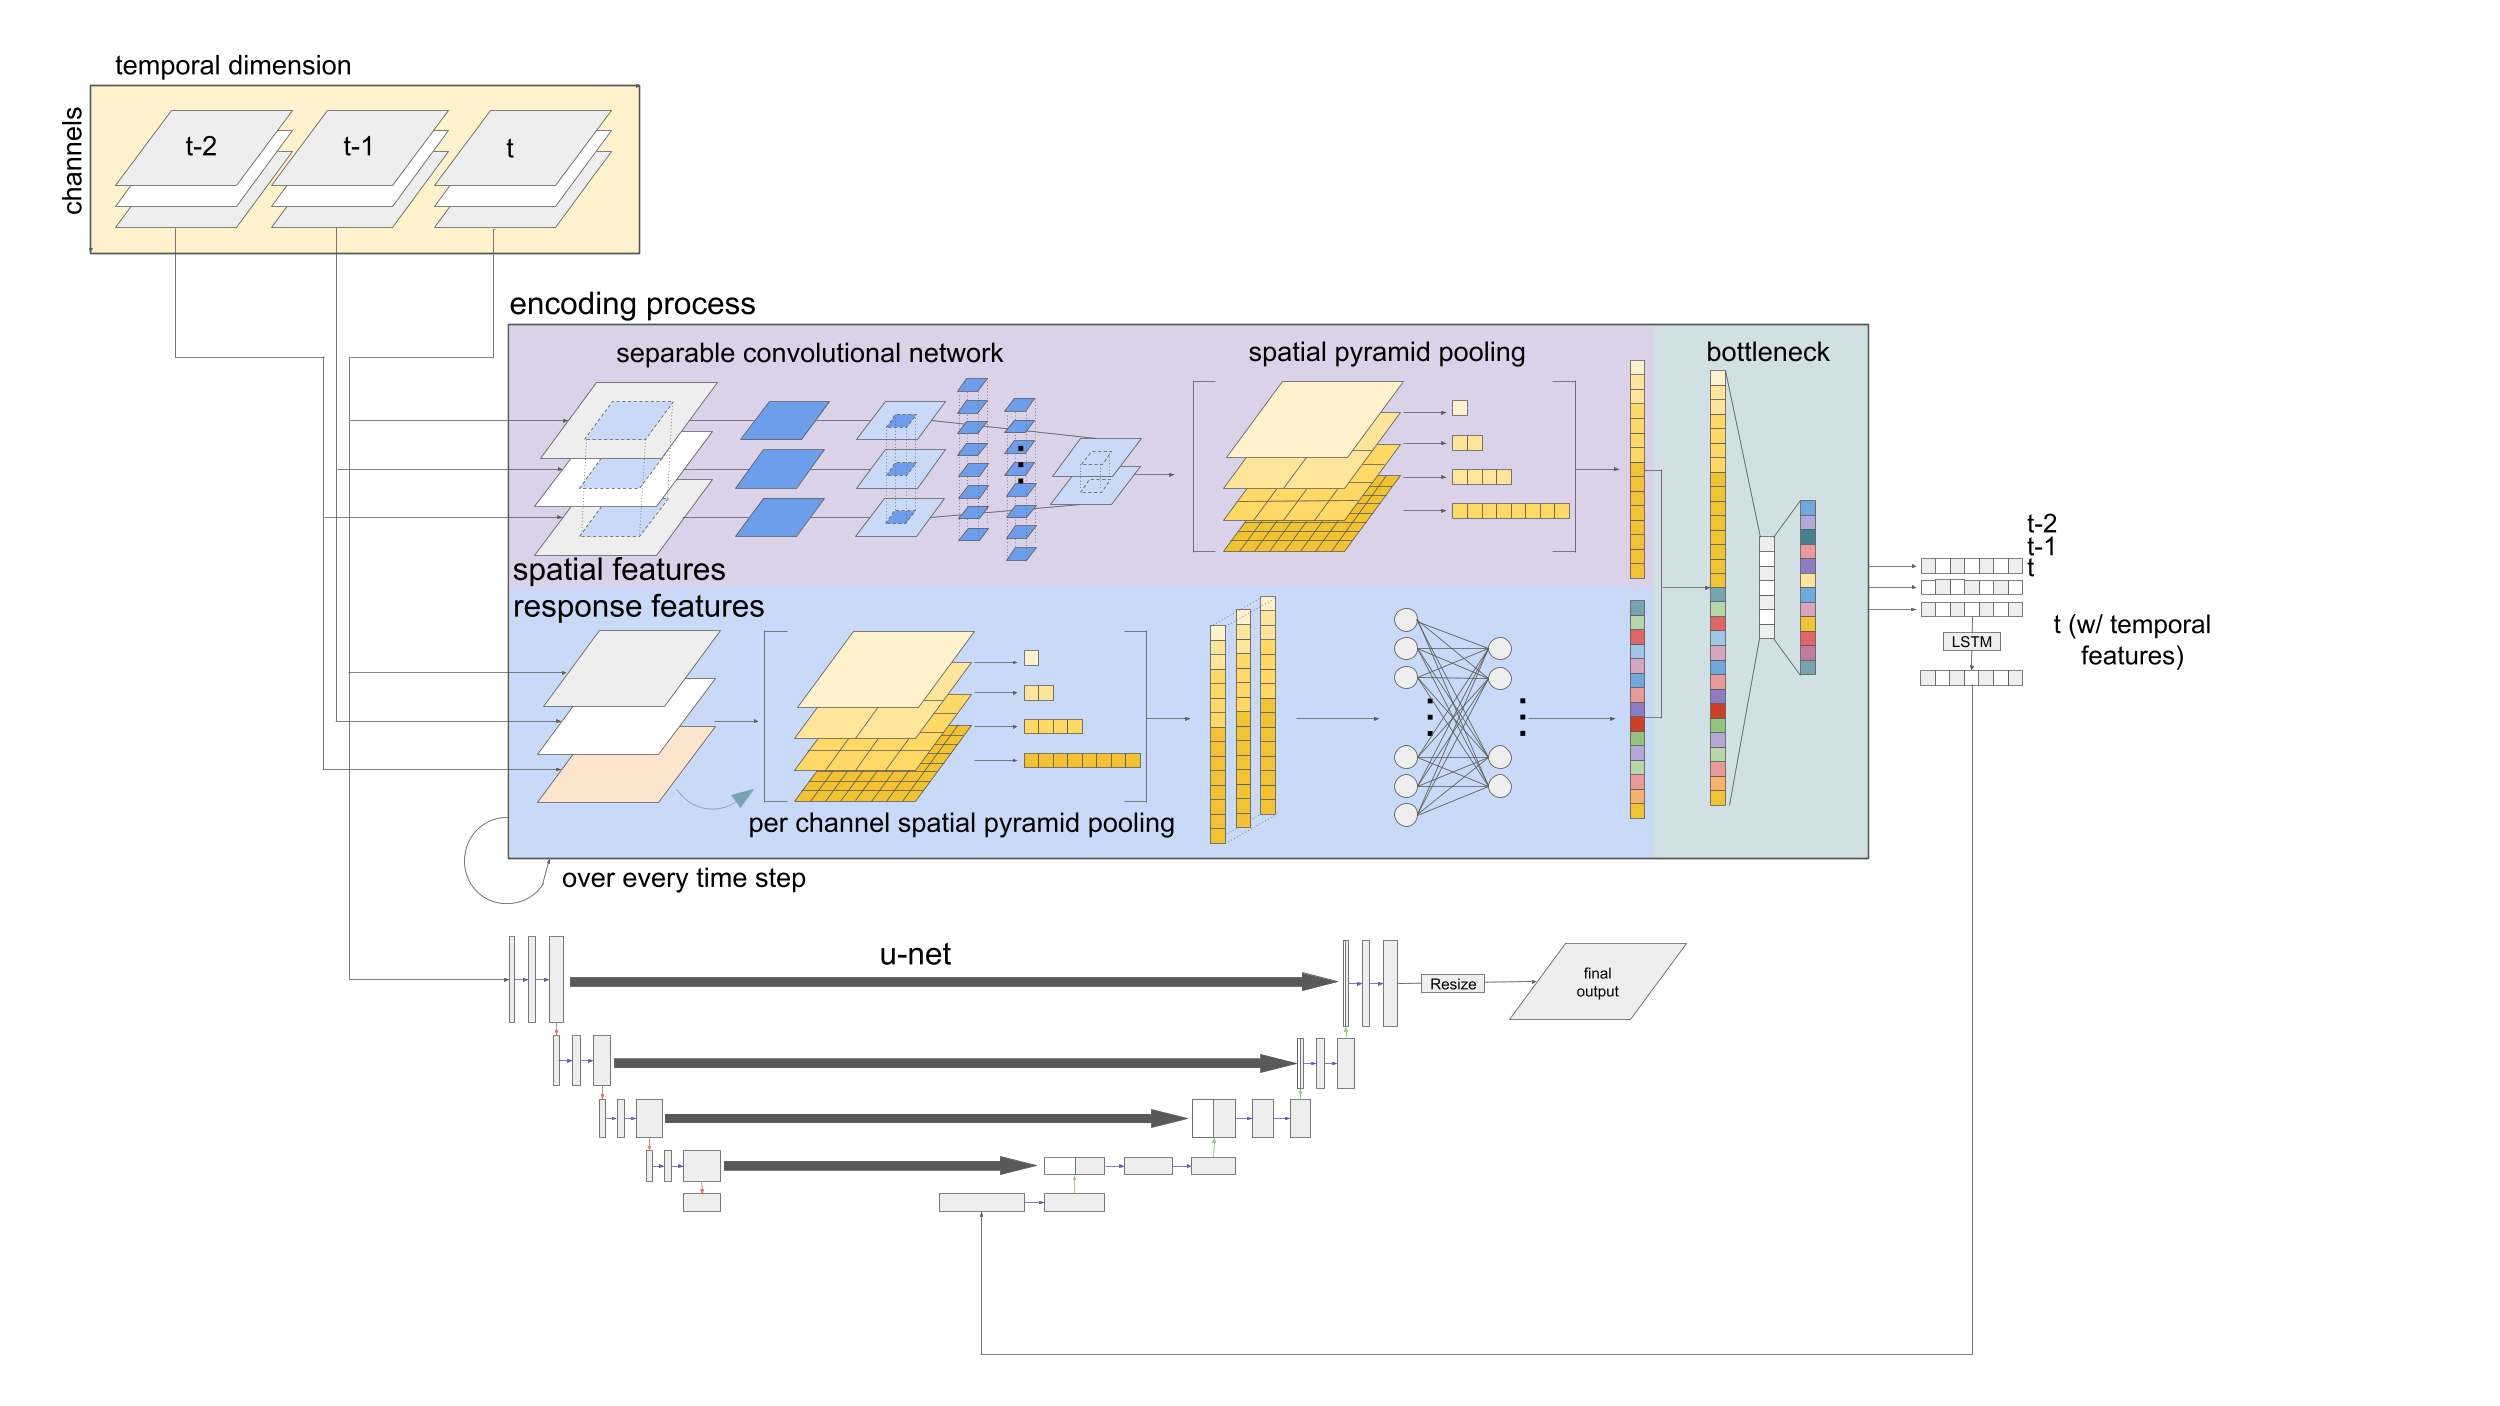

In [6]:
from tensorflow.keras.layers import SpatialDropout2D, \
    BatchNormalization, LeakyReLU, Dense, SeparableConv2D, \
    InputSpec, Input, Concatenate, Reshape, Conv2D, Conv2DTranspose, \
    Activation, add, concatenate, UpSampling2D, MaxPool2D, CenterCrop, \
    Permute, Lambda, Resizing, TimeDistributed, LSTM, Flatten

import tensorflow as tf
import numpy as np
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    try:
        from tensorflow_addons.layers import SpatialPyramidPooling2D
    except ModuleNotFoundError:
        !pip install tensorflow_addons
        from tensorflow_addons.layers import SpatialPyramidPooling2D

def CustomEncoder(batch_size, t):
    height = 248
    initializer = tf.keras.initializers.\
                        GlorotUniform(seed=np.random.seed(37))
    bins = [1, 2, 4]
    input_spec = (248, 572, 3)
    concatenated = Input(input_spec, batch_size=batch_size)

    # Merge 1: Spatial Features
    spatial_features = SeparableConv2D(filters=height, kernel_size=(3, 3),
                                        padding='same', data_format='channels_last',
                                        depthwise_initializer=initializer)(concatenated)
    normalized_spatial_features = BatchNormalization()(spatial_features)
    dropped_normalized_spatial_features = SpatialDropout2D(0.2)(normalized_spatial_features)
    activated_normalized_spatial_features = LeakyReLU(alpha=0.01)(dropped_normalized_spatial_features)
    flattened_spatial_features = SpatialPyramidPooling2D(bins, data_format='channels_last') \
                                                        (activated_normalized_spatial_features)

    # Merge 2: Response Features
    num_channels = concatenated.shape[-1]
    pooled_features_list = []
    for channel in range(num_channels):
        current_channel = tf.expand_dims(concatenated[:, :, :, channel], axis=-1)
        pooled_features = SpatialPyramidPooling2D(bins, data_format='channels_last')(current_channel)
        pooled_features_list.append(pooled_features)

    flattened_response_features = tf.concat(pooled_features_list, axis=-1)
    linear_flattened_response_features = Dense(units=height)(flattened_response_features)

    # Flatten and Concatenate
    flattened_spatial = Flatten()(flattened_spatial_features)
    flattened_response = Flatten()(linear_flattened_response_features)

    concatenated_features = Concatenate(axis=-1)([flattened_spatial, flattened_response])
    reduced_features = Dense(units=20, activation='relu')(concatenated_features)  # example value
    final_output = Dense(units=height//2, activation="sigmoid")(reduced_features)

    model = tf.keras.Model(
        inputs=concatenated,
        outputs=final_output,
        name=f"Encoder_{t}"
    )

    return model

def conv_block(x, num_filters):
    regularizer = tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
    initializer = tf.keras.initializers.GlorotUniform(seed=seed)
    x = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer=initializer, \
               kernel_regularizer=regularizer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)

    x = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer=initializer, \
               kernel_regularizer=regularizer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)

    return x

height, width = (248, 572)
sequence_length = 3
batch_size = 10
spatial_input_spec = (sequence_length, height, width)

X = Input(shape=spatial_input_spec, batch_size=batch_size, name="pr")
Y = Input(shape=spatial_input_spec, batch_size=batch_size, name="th")
Z = Input(shape=spatial_input_spec, batch_size=batch_size, name="vs")
concatenated = tf.stack([X, Y, Z], axis=-1)

inputs_list = [X, Y, Z]
outputs = []

for t in range(sequence_length): # manual timedistributed layer, change later?
    current_concatenated = concatenated[:, t, :, :]
    current_feature = CustomEncoder(batch_size=batch_size, t=t)(current_concatenated)
    outputs.append(current_feature)

features = tf.stack(outputs, axis=1)

proc = LSTM(units=height, return_sequences=False, dropout=0.2)(features)

# Flatten and decode the output
final_features = Dense(units=7*16, activation="sigmoid")(proc)

x = Reshape((7, 16, 1))(final_features)

# Upscale using Conv2DTranspose layers
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 14x32
x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 28x64
x = Conv2DTranspose(8, (3, 3), strides=(3, 2), padding='same', activation='relu')(x)   # 84x128
x = Conv2DTranspose(4, (3, 3), strides=(3, 5), padding='same', activation='relu')(x)   # 252x640

final_output = Resizing(248, 572)(x) # consider lanczos interpolation method?

model = tf.keras.Model(inputs=[X, Y, Z], outputs=final_output, name="ClimateDetectionModel")
model.summary(expand_nested=True)


X.shape=TensorShape([10, 3, 248, 572])
Model: "ClimateDetectionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 pr (InputLayer)             [(10, 3, 248, 572)]          0         []                            
                                                                                                  
 th (InputLayer)             [(10, 3, 248, 572)]          0         []                            
                                                                                                  
 vs (InputLayer)             [(10, 3, 248, 572)]          0         []                            
                                                                                                  
 tf.stack_10 (TFOpLambda)    (10, 3, 248, 572, 3)         0         ['pr[0][0]',                  
                                       

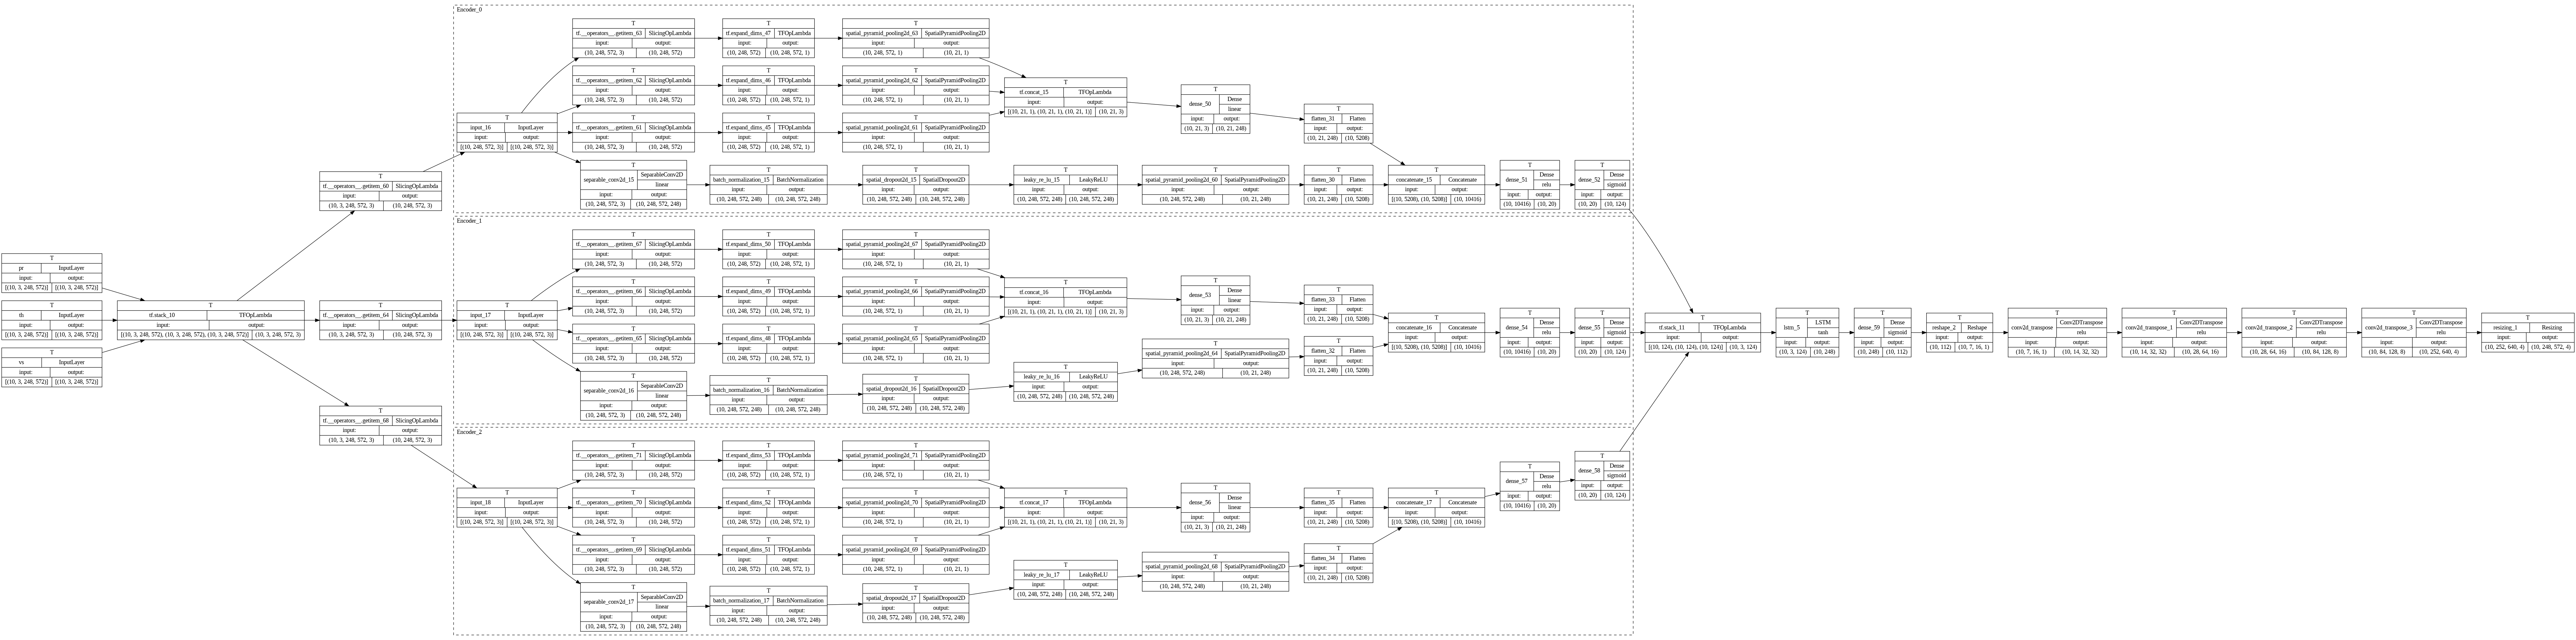

In [8]:
tf.keras.utils.plot_model(model, to_file="model_1.png", show_shapes=True, \
                          show_layer_activations=True, show_trainable=True, \
                          expand_nested=True, rankdir="LR")

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.F1Score(),
             tf.keras.metrics.BinaryCrossentropy(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()],
    run_eagerly=True
)

In [ ]:
model.save(filepath="model.keras", save_format="keras")

In [ ]:
# a = create_model(572, 248, 10)
a = create_model(height=248, width=572, batch_size=10)
print(a.summary(expand_nested=True, show_trainable=True))
# tf.keras.utils.plot_model(a, to_file="model_1.png", show_shapes=True, \
#                           show_layer_activations=True, show_trainable=True, \
#                           expand_nested=True, rankdir="LR")

KerasTensor(type_spec=TensorSpec(shape=(10, 248, 572, 3), dtype=tf.float32, name=None), name='tf.stack_5/stack:0', description="created by layer 'tf.stack_5'")


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "ClimateDetectionModel"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 pr (InputLayer)                [(10, 248, 572)]     0           []                               Y          
                                                                                                             
 th (InputLayer)                [(10, 248, 572)]     0           []                               Y          
                                                                                                             
 vs (InputLayer)                [(10, 248, 572)]     0           []                               Y          
                                                                                                             
 day (InputLayer)               [(10,)]              0           []                      

### Model 4: ding! ding ding ding! ding ding! ding ding ding!


## Load Data
---
A simple stage
1.   Unpickle tupled items
2.   Unpack data
3.   Tensorize arrays

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


⚠**IMPORTANT**⚠: only run this step _if_ the first two models are being run; this step takes about a minute to run and it consumes a significant part of the RAM. In fact, this step can _only_ run if it is on a high-RAM instance, and thus any code relating to these variables should be treated with the upmost care to ensure that the runtime does not exhaust all the allocated memory.

In [ ]:
import pickle
with open("drive/MyDrive/precomp_inputs.BYTES", "rb") as f:
    X_data_train, X_data_test, y_train, y_test, height, width \
        = pickle.load(f)

**Remark**: the reason for this next cells (labeled as "*Model 1*" and "*Model 2*" on the file hierarchy) is due to a series of problems which accumulated throughout trying to run the model. These problems include


*   Unmatching dtypes (org. float32's and int8's, neither of which would correctly have represented the datas correctly; int16's where decided on because int8's range is not within the integer datetime and the boolean mask is represented as a boolean 1/0)
*   Dictionaries and other such non-optimized large data-containers would not have worked due to the excessive amount of RAM needed to contain them. Therefore, Tensorflow Datasets were used instead. ***NB***: datasets have a special property such that inputting one into a Tensorflow model makes it so that the y-component does not need to be specified. This is why the requisite zipping is done before the Datasets are batched ([pertinent documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit:~:text=If%20x%20is%20a%20dataset%2C%20generator%2C%20or%20keras.utils.Sequence%20instance%2C%20y%20should%20not%20be%20specified%20(since%20targets%20will%20be%20obtained%20from%20x).)).
*   While ```X_data_train``` and ```X_data_test``` have boolean masks of dtype ```np.int16``` by default, ``` y_train``` and ```y_test``` do not. This is because of code used previously to generate the pickled input data which did not account for the future dtype discrepency. To fix this, the subarrays have to be cast to int64's before being fully instantiated Datasets (Note: Datasets' dtypes are only checked *when* they are first explicitly used, *not* when they are declared).




### Model 1
Loading the data to this model is subtly different from the tripartite implementation since there are three outputs instead of one.

In [ ]:
import numpy as np
import tensorflow as tf

print(1)

def data_generator(data_list):
    for data_tuple in data_list:
        yield data_tuple[0], data_tuple[1], data_tuple[2], data_tuple[3]

train_data_gen = data_generator(X_data_train)

input_spec = (
    tf.TensorSpec(shape=(), dtype=tf.int16),                   # days_inputs_train
    tf.TensorSpec(shape=(3,height,width), dtype=tf.int16),     # storm_inputs_train
    tf.TensorSpec(shape=(3,height,width), dtype=tf.int16),     # hail_inputs_train
    tf.TensorSpec(shape=(3,height,width), dtype=tf.int16)      # wind_inputs_train
)

# Create TensorFlow dataset
X_final_train = tf.data.Dataset.from_generator(lambda: data_generator(X_data_train), \
                                            output_signature=input_spec)
print(X_final_train)

def _data_generator(data_list):
    for data_tuple in data_list:
        yield data_tuple[0]

output_spec = (
    tf.TensorSpec(shape=(height,width), dtype=tf.int16)
)

y_final_train = tf.data.Dataset.from_generator(lambda: _data_generator(y_train), \
                                               output_signature=output_spec)
print(y_final_train)
print(3)

1
<_FlatMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.int16, name=None), TensorSpec(shape=(3, 248, 572), dtype=tf.int16, name=None), TensorSpec(shape=(3, 248, 572), dtype=tf.int16, name=None), TensorSpec(shape=(3, 248, 572), dtype=tf.int16, name=None))>
<_FlatMapDataset element_spec=TensorSpec(shape=(248, 572), dtype=tf.int16, name=None)>
3


In [ ]:
def output_to_dict(storm, hail, wind):
    # storm, hail, wind = data
    return {
        'storm_output': tf.cast(storm, tf.int16)
    }
# X_final_train should be fine???
y_final_train = y_final_train.map(lambda a, b, c: output_to_dict(a, b, c))

In [ ]:
final_test_X = tf.data.Dataset.from_generator(lambda: data_generator(X_data_test), \
                                              output_signature=input_spec)

final_test_y = tf.data.Dataset.from_generator(lambda: _data_generator(y_test), \
                                              output_signature=output_spec)

final_test_y = final_test_y.map(lambda a, b, c: output_to_dict(a, b, c))

**Remark**: Due to how the model works, the input must be of the same dimensionality and shape. However, if the full size of the dataset is not divisible by the batch size, then there is a residual remainder. This remainder is not by default trimmed from the batching process, and thus needs to be specified. Not doing so leads to a ```ValueError``` from unmatching shape during the fitting process. The next 4 cells after the batching cell is entirely for troubleshooting purposes and merely check for any discrepency in the practical and expected shapes.

In [ ]:
zipped = tf.data.Dataset.zip((X_final_train, y_final_train))
zipped_n_batched = zipped.batch(16, drop_remainder=True)
zipped_validation = tf.data.Dataset.zip((final_test_X, final_test_y))
zipped_n_batched_validation = zipped_validation.batch(16, drop_remainder=True)

In [ ]:
for ind, i in enumerate(X_final_train):
  assert (i[0].shape, i[1].shape, i[2].shape, i[3].shape) == ((), (3, 248, 572), (3, 248, 572), (3, 248, 572)), \
    f"{(i[0].shape, i[1].shape, i[2].shape, i[3].shape)}, {ind=}"

In [ ]:
for ind, i in enumerate(y_final_train):
  assert (i["storm_output"].shape, i["hail_output"].shape, i["wind_output"].shape) \
    == ((248, 572), (248, 572), (248, 572)), \
    str(i["storm_output"].shape, i["hail_output"].shape, i["wind_output"].shape) + str(ind)

In [ ]:
for ind, i in enumerate(zipped_n_batched):
  _in, _out = i[0], i[1]
  _flag_1 = _in[0].shape == (25,)
  _flag_2 = _in[1].shape == (25, 3, 248, 572)
  _flag_3 = _in[2].shape == (25, 3, 248, 572)
  _flag_4 = _in[3].shape == (25, 3, 248, 572)
  _flag_5 = _out["storm_output"].shape == (25, 248, 572)
  _flag_6 = _out["hail_output"].shape == (25, 248, 572)
  _flag_7 = _out["wind_output"].shape == (25, 248, 572)
  code = [_flag_1, _flag_2, _flag_3, _flag_4, _flag_5, _flag_6, _flag_7]
  if not all(code):
    print(f"index {ind} has code {code}")

In [ ]:
print(len(X_data_train))
# _in, _out = i[0], i[1]
# print(f"{_in[0].shape=}\n{_in[1].shape=}\n{_in[2].shape=}\n{_in[3].shape=}\n=======")
# print(f"{_out['storm_output'].shape=}\n {_out['storm_output'].shape=}\n {_out['storm_output'].shape=}")

5433


### Model 2
This differs from Model 1's loading due to the reduced number of outputs. Consequentially, the data needs to be proceed more explictly than in Model 1's implementation. *NB*: since this implementation opts to not use generators, it is inheriently RAM-intensive.

In [ ]:
import numpy as np
import tensorflow as tf

def data_generator(data_list):
    for data_tuple in data_list:
        yield data_tuple[0], data_tuple[1], \
              data_tuple[2], data_tuple[3]

train_data_gen = data_generator(X_data_train)

input_spec = (
    tf.TensorSpec(shape=(), dtype=tf.float32),                   # days_inputs_train
    tf.TensorSpec(shape=(3,height,width), dtype=tf.float32),     # storm_inputs_train
    tf.TensorSpec(shape=(3,height,width), dtype=tf.float32),     # hail_inputs_train
    tf.TensorSpec(shape=(3,height,width), dtype=tf.float32)      # wind_inputs_train
)

X_final_train = tf.data.Dataset.from_generator(lambda: data_generator(X_data_train), \
                                            output_signature=input_spec)

final_test_X = tf.data.Dataset.from_generator(lambda: data_generator(X_data_test), \
                                              output_signature=input_spec)

In [ ]:
def _data_generator(data_list):# THIS COULD BE A PROBLEM !!!!!!!!!!!!!!!!!!!!!!!!
    for data_tuple in data_list:# THIS COULD BE A PROBLEM !!!!!!!!!!!!!!!!!!!!!!!!
        yield tf.cast(data_tuple, tf.float32)# THIS COULD BE A PROBLEM !!!!!!!!!!!!!!!!!!!!!!!!

output_spec = (
    tf.TensorSpec(shape=(height,width), dtype=tf.float32)     # storm_outputs_train
)

# _y_train = tuple(tuple(tf.cast(i[0], tf.float32)) for i in y_train)

y_final_train = tf.data.Dataset.from_generator(lambda: _data_generator(y_train[0]), \
                                              output_signature=output_spec)# THIS COULD BE A PROBLEM !!!!!!!!!!!!!!!!!!!!!!!!

# _y_test = tuple(tuple(tf.cast(i[0], tf.float32)) for i in y_test)

final_test_y = tf.data.Dataset.from_generator(lambda: _data_generator(y_test[0]), \
                                              output_signature=output_spec)

In [ ]:
zipped = tf.data.Dataset.zip((X_final_train, y_final_train))
zipped_n_batched = zipped.batch(16, drop_remainder=True)
zipped_validation = tf.data.Dataset.zip((final_test_X, final_test_y))
zipped_n_batched_validation = zipped_validation.batch(16, drop_remainder=True)

In [ ]:
print(next(iter(X_final_train)))

(<tf.Tensor: shape=(), dtype=float32, numpy=5253.0>, <tf.Tensor: shape=(3, 248, 572), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>, <tf.Tensor: shape=(3, 248, 572), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 

In [ ]:
for i in zipped_n_batched:
    print(i)
    break
# print(next(iter(zipped_n_batched)))
# for i in y_final_train:
#     [print(k.shape) for k in i[0]]
#     break

### Model 3
<figure>
<center>
<img src='https://i.ibb.co/j6kPBGF/mermaid-diagram-2023-08-16-150951.png' />
<figcaption>Link: <a href=https://i.ibb.co/j6kPBGF/mermaid-diagram-2023-08-16-150951.png>https://i.ibb.co/j6kPBGF/mermaid-diagram-2023-08-16-150951.png</a></figcaption></center>
</figure>

<figure>
<center>
<img src='https://mermaid.ink/img/pako:eNq1VVtvmzAU_ivIDwuRQoRtCCFaKnXq4y7SuqdBNTnYaZHApsa00CT_fcY0CTTJplWaFQX8ne8cn6vZgERQBhZgnYnn5IFIZX3-HnNLr7Ja3UtSPFiJyDKWqFTwTtAumsoOsn58OqIHlfqItauQ4imyBc9SzixKFFmRko3vhiTHubK2VDzzTBC6pasmsjORkOyiQkFxFMWgoFPNYL8k4ffMHlJKpSNajpALPcf1HRSMJhcICDkQORi-Jawle1yObkbjIZwxvpwFIR6iMbg79dH6YOlgTHiZEAXatP87s9fSN2ZbghFRZNu0yotx72DG6ZlcN29PhH_LyoXMWKcsfaJJDnZcqH9nORcy1MuS1-bFRDWkbCXLxROzSvZYMZ6wbUHRO3zH7n_0HZ7WlK7qyP767frakqwQUpWnjYkO5YaDcqMTS13bp4pJolKdi8MAGOXTCaHwD31xeDk0R6FdlCI5N7j7OW9XXdu2ZIRaKbfq8dicVMOo_riSVyYRYYB7Qdawc_tYP61Iy22Nolc27LGb5mi8eTXewKjpGUd9-tC4A1vb2-asaUqaf7wC2mYZEvZ98o4LQDtzaO26V9sG6aGvuyZ4SYtznmvYiJUkKTcE3w9md1rviWRmD3Ho9xQMsRMbxVzf25ltm8e-GXQoYAJyJnOSUn2pb1o4BuqB5SwGC_1K2ZpUmYpBzHeaSiolbhuegIWSFZuAqmjzeJMS3T35HmQ0VUJ-6b4T5nMxAQXhP4XQlDXJSmb2YLEBNVg4CE_RzA9dD83COfaw501Ao3HoungazufYR_4M-R7Euwl4MUZQiwduEITuPPAxDIPdb_GyuU0?type=png' />
</center>
</figure>


In [ ]:
import tensorflow as tf
import pickle
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# %cd drive/MyDrive
print("==========\nloading dataset 1")
data = tf.data.Dataset.load("drive/MyDrive/nc_model_input", compression='GZIP')

# print("pickling")
# with open("precomp_inputs.BYTES", "rb") as f:
#     _, _, y_train, y_test, _, _ = pickle.load(f)
print("loading dataset 2")
y = tf.data.Dataset.load("drive/MyDrive/y", compression="GZIP")

Mounted at /content/drive
loading dataset 1
loading dataset 2


In [ ]:
# del _

In [ ]:
# output_spec = (
#     tf.TensorSpec(shape=(248, 572), dtype=tf.int16)
# )

# def _data_generator(data_list):
#     for data_tuple in data_list:
#         yield data_tuple[0]

# print("training y dataset")
# training_y = tf.data.Dataset.from_generator(lambda: _data_generator(y_train), \
#                                                output_signature=output_spec)

# print("validation y dataset")
# validation_y = tf.data.Dataset.from_generator(lambda: _data_generator(y_test), \
#                                             output_signature=output_spec)

~TODO: FIX  VAL NOT EXISTING~

TODO: FIX UNIFORM PREDICTIONS


In [ ]:
import numpy as np
import pandas as pd
"""
since days are encoded by the number of days since the initial,
the effective result is just a range of numbers of cardinality
DATASET_SIZE/3. overcounting is caused by the three different datatypes
for both datasets.

dataset_size := final dataset size
"""
DATASET_SIZE = 6791

# days = np.linspace(0, DATASET_SIZE-1, DATASET_SIZE, dtype=np.int16)

# def day_generator(day_list):
#     for day in day_list:
#         yield {"day": day}

# day_spec = {
#     "day": tf.TensorSpec(shape=(), dtype=tf.int16)
# }

# day_column = tf.data.Dataset.from_generator(lambda: day_generator(days), output_signature=day_spec)
data_skipped = data.skip(3)
# final_X = tf.data.Dataset.zip((data, day_column))
# flattened_X = final_X.map(lambda a, b: a | b)

y_last_removed = y.take(DATASET_SIZE)
# pre_zipped = tf.data.Dataset.zip((flattened_X, y_last_removed))
pre_zipped = tf.data.Dataset.zip((data_skipped, y_last_removed))
shuffled = pre_zipped.shuffle(DATASET_SIZE, reshuffle_each_iteration=True)
shuffled_n_batched = shuffled.batch(10)
# add one to the test size
# source: trust me bro
DATASET_SIZE_POST_BATCH = DATASET_SIZE // 10
TRAIN, TEST = int(0.8*DATASET_SIZE_POST_BATCH), int(0.2*DATASET_SIZE_POST_BATCH)+2
# 2004-5-27           2023-1-1
# |-------/           |------/
# |----/              |----/
# |/                  |/
# _ _ _ 1 2 3 ... n-1 n
# x x x | | | ||| |   x
# x x x | | | ||| |   x
# X X X 1 2 3 ... n-1 N/A
#|-----| seq      |    |
#                 |    |
#                 |    |-y dataset size goes to 2023-1-1
#                 |-DATSET_SIZE goes to 2022-12-31, 1 less
#                   so last elem is automatically omitted

# assert bijectiveness
# assert TRAIN + TEST == len(y_train) + len(y_test)

train = shuffled_n_batched.take(TRAIN)
val = shuffled_n_batched.skip(TRAIN)

val.element_spec

({'vs': TensorSpec(shape=(None, 248, 572), dtype=tf.float32, name=None),
  'th': TensorSpec(shape=(None, 248, 572), dtype=tf.float32, name=None),
  'pr': TensorSpec(shape=(None, 248, 572), dtype=tf.float32, name=None)},
 TensorSpec(shape=(None, 248, 572), dtype=tf.int16, name=None))

In [ ]:
TRAIN + TEST

679

In [ ]:
_iter = iter(val)
next(_iter)

({'vs': <tf.Tensor: shape=(10, 248, 572), dtype=float32, numpy=
  array([[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
  
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
  
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
  
         ...,
  
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
 

In [ ]:
dataset = tf.data.Dataset.range(10)
a = dataset.take(7)
b = dataset.skip(7)
list(a.as_numpy_iterator()), list(b.as_numpy_iterator())

([0, 1, 2, 3, 4, 5, 6], [7, 8, 9])

In [ ]:
train.save("data", compression="GZIP")
val.save("data", compression="GZIP")

In [ ]:
_iter = iter(val)
for i in range(2):
    a = next(_iter)
    break

import numpy as np
print((~np.isnan(a["th"].numpy())).all())

StopIteration: ignored

In [ ]:
array = tf.Variable(
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
)
check_numerics(array, "asdasd")

InvalidArgumentError: ignored

In [ ]:
for i in range(100):
    dt = 100*(np.random.rand(248, 572)) # > 0.5
    dt = np.expand_dims(dt, [0, -1])
    b1 = lambda a: SeparableConv2D(kernel_size=(3, 3), padding='same', filters=248, data_format="channels_last")(a)
    b2 = lambda a: BatchNormalization()(a)
    b3 = lambda a: SpatialDropout2D(0.1)(a)
    b4 = lambda a: LeakyReLU(alpha=0.01)(a)
    b5 = lambda a: SpatialPyramidPooling2D([6, 9, 13], data_format='channels_last')(a)

    chained = lambda a: b5(b4(b3(b2(b1(a)))))

    bs = (b1, b2, b3, b4, b5, chained)
    for i, b in enumerate(bs):
        proc = b(dt).numpy()
        flag = (~np.isnan(proc)).any()
        print(i+1, flag, end=" | ")
        if not flag: raise ValueError("nan happens", proc)

    print("\n")

1 True | 2 True | 3 True | 4 True | 5 True | 6 True | 

1 True | 2 True | 3 True | 4 True | 5 True | 6 True | 

1 True | 2 True | 3 True | 4 True | 5 True | 6 True | 

1 True | 2 True | 3 True | 4 True | 5 True | 

KeyboardInterrupt: ignored

In [ ]:
concatenated = 100*np.random.rand(1, 248, 572, 3)
num_channels = concatenated.shape[-1]
pooled_features_list = []
for channel in range(num_channels): # note that by the paper, SPP should be applied channel-wise
    current_channel = tf.expand_dims(concatenated[:, :, :, channel], axis=-1)
    # print(current_channel)
    pooled_features = SpatialPyramidPooling2D([6, 9, 13], data_format='channels_last')(current_channel)
    pooled_features_list.append(pooled_features)

flattened_response_features = tf.concat(pooled_features_list, axis=-1)
# print(flattened_response_features)
linear_flattened_response_features = Dense(units=248)(flattened_response_features)
print(linear_flattened_response_features)
1/0

tf.Tensor(
[[[-0.41666973 -7.6837206  -7.390988   ...  3.2360544  -4.163037
    7.1737514 ]
  [-0.33407986 -7.6329308  -7.3293743  ...  3.1485555  -4.1575737
    6.9364963 ]
  [-0.32391727 -7.7196984  -7.4381776  ...  3.143902   -4.210413
    6.9481163 ]
  ...
  [-0.32426018 -7.7345586  -7.380754   ...  3.2244372  -4.2141433
    7.048863  ]
  [-0.36515558 -7.6749935  -7.4957914  ...  3.0636508  -4.1799445
    6.895222  ]
  [-0.41714972 -7.618545   -7.29675    ...  3.245472   -4.1246176
    7.161971  ]]], shape=(1, 286, 248), dtype=float32)


ZeroDivisionError: ignored

In [ ]:
model = create_model(height=248, width=572, batch_size=1)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
tf.debugging.disable_check_numerics()
torn = 1 * (np.random.rand(248, 572) > 0.5)
torn = np.array([torn])
hail = 1 * (np.random.rand(248, 572) > 0.5)
hail = np.array([hail])
wind = 1 * (np.random.rand(248, 572) > 0.5)
wind = np.array([wind])

pred = model.predict(
    {"pr": torn,
     "th": hail,
     "vs": wind #,
     # "day": np.array([10])
     }
)

1/1 [==============================] - 2s 2s/step


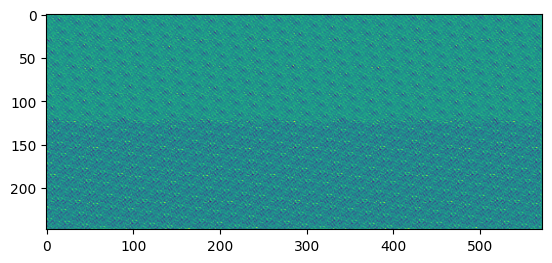

In [ ]:
_pred = np.reshape(pred, (248, 572))
import matplotlib.pyplot as plt
plt.imshow(_pred)
plt.show()

In [ ]:
BatchNormalization()(np.zeros((10, 20))+np.random.random((10, 20))/100)

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[8.6836452e-03, 2.5838304e-03, 9.2242695e-03, 3.2658463e-03,
        2.0146701e-03, 3.1541006e-03, 7.9497322e-03, 2.8777873e-04,
        2.0703813e-03, 5.4181162e-03, 6.0735331e-03, 7.4969949e-03,
        7.8937802e-03, 1.4698867e-03, 7.0666280e-03, 5.0734477e-03,
        6.0228454e-03, 2.5762303e-03, 3.6074410e-03, 8.6929025e-03],
       [7.3179934e-04, 4.0789042e-03, 7.2004604e-03, 2.9719819e-03,
        5.2214507e-03, 6.4659612e-03, 6.5129176e-03, 8.1293727e-04,
        4.9629565e-03, 8.5715549e-03, 3.4702821e-03, 9.6674804e-03,
        9.4199814e-03, 3.7800934e-04, 5.2664303e-03, 2.3428923e-03,
        3.9415089e-03, 7.0328088e-03, 3.1178684e-03, 2.5259906e-03],
       [4.5619146e-03, 8.0458093e-03, 6.4468831e-03, 5.1950417e-03,
        8.2239211e-03, 6.7645335e-03, 3.3576612e-03, 1.6638895e-03,
        8.8595031e-03, 1.3305951e-03, 2.1911650e-03, 3.5026388e-03,
        3.3517687e-03, 8.5821468e-03, 3.9345687e-03, 8.4631965e-

In [ ]:
tf.debugging.experimental.enable_dump_debug_info(
    "/tmp/tfdbg2_logdir",
    tensor_debug_mode="FULL_HEALTH",
    circular_buffer_size=-1)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
    run_eagerly=True
)
%cd drive/MyDrive
history = model.fit(next(iter(train)),
                    validation_data=next(iter(val)),
                    batch_size=10,
                    epochs=1,
                    callbacks=callbacks,
                    verbose=1)

/content/drive/MyDrive


StopIteration: ignored

## Compilation and Training
---
~Self-explanatory. Without a stronger local or cloud computer, this model cannot proceed training.~ This is not true anymore.

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    # catch warning about glorot initialization seeding bc
    # [redacted]
    model = create_model(height=248, width=572, batch_size=10)

print(model.summary())
# tf.keras.utils.plot_model(model, to_file="model_1.png", show_shapes=True, \
#                           show_layer_activations=True, show_trainable=True, \
#                           expand_nested=True, rankdir="LR")

Model: "ClimateDetectionModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pr (InputLayer)                [(10, 248, 572)]     0           []                               
                                                                                                  
 th (InputLayer)                [(10, 248, 572)]     0           []                               
                                                                                                  
 vs (InputLayer)                [(10, 248, 572)]     0           []                               
                                                                                                  
 ClimateEncoder (Functional)    (10, 572, 248)       3003        ['pr[0][0]',                     
                                                                  'th[0][0]', 

**Remark**: Note that ```sparse_categorical_crossentropy``` was not used in this case since the output cases are not mutually exclusive, i.e. the output is a list of *probabilities* over a mask and not just a singular point. This is why ```categorical_crossentropy``` is used instead.

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.F1Score(),
             tf.keras.metrics.BinaryCrossentropy(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()],
    run_eagerly=True
)

**Remark**: While callbacks are *technically* optional, and *do* dampen preformance to a certain extent, their long-term benifits are increased optimizability (Tensorboard), visualization curves and weight saving to prevent overfitting (Tensorboard, ModelCheckpoint), and early stopping, based on validation accuracy, again for overfitting (EarlyStopping)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_checkpoint.h5",
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    checkpoint_callback,
    tf.keras.callbacks. \
      EarlyStopping(monitor='val_loss', patience=2, mode='min', verbose=1)
]

**Remark**: Due to resource exhaustion, the model has not yet completed one epoch yet. As such, it is ambiguous to the correctness of the validation; the ```validation_data``` paramater will most likly return some error when an epoch is finally over. The solution will most likely be the same as with the input data, i.e. ```Dataset.zip(...)```, however, this is to be seen with future optimizations in the model. (outdated)

**Remark**: There seems to be a pattern when running this code that if the code is interrupted, somehow the link between the VM's CPU and GPU break. Note from the error below the error \\
> *TLDR;* \\
> `Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Cast: Dst tensor is not initialized. [Op:Cast]`

<details>
<summary> Full python callback</summary>
<pre><code>
---------------------------------------------------------------------------
InternalError                             Traceback (most recent call last)
&lt;ipython-input-20-fb874d3f8f2a&gt; in <cell line: 3>()
      1 zipped = tf.data.Dataset.zip((X_final_train, y_final_train))
      2 zipped_n_batched = zipped.batch(10)
----> 3 model.fit(zipped_n_batched,
      4           validation_data=(X_data_test, y_test),
      5           batch_size=10,

/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py in error_handler(*args, **kwargs)
     68             # To get the full stack trace, call:
     69             # `tf.debugging.disable_traceback_filtering()`
---> 70             raise e.with_traceback(filtered_tb) from None
     71         finally:
     72             del filtered_tb

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py in raise_from_not_ok_status(e, name)
   7260 def raise_from_not_ok_status(e, name):
   7261   e.message += (" name: " + name if name is not None else "")
-> 7262   raise core._status_to_exception(e) from None  # pylint: disable=protected-access
   7263
   7264

InternalError: Exception encountered when calling layer 'model_1' (type Functional).

Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Cast: Dst tensor is not initialized. [Op:Cast]

Call arguments received by layer 'model_1' (type Functional):
  • inputs=('tf.Tensor(shape=(10,), dtype=int16)', 'tf.Tensor(shape=(10, 3, 248, 572), dtype=int16)', 'tf.Tensor(shape=(10, 3, 248, 572), dtype=int16)', 'tf.Tensor(shape=(10, 3, 248, 572), dtype=int16)')
  • training=True
  • mask=None
</code></pre>
</details>

In [ ]:
%%time
# model.fit(zipped_n_batched,
#           validation_data=zipped_n_batched_validation,
#           batch_size=16,
#           epochs=10,
#           callbacks=callbacks,
#           verbose=1)
history = model.fit(train,
                    validation_data=val,
                    batch_size=10,
                    epochs=5,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/5


543/543 [==============================] - ETA: 0s - loss: 1.4601 - accuracy: 0.9781
Epoch 1: val_loss improved from inf to 0.14221, saving model to model_checkpoint.h5
543/543 [==============================] - 358s 526ms/step - loss: 1.4601 - accuracy: 0.9781 - val_loss: 0.1422 - val_accuracy: 0.9982
Epoch 2/5
543/543 [==============================] - ETA: 0s - loss: 0.1248 - accuracy: 0.9983
Epoch 2: val_loss improved from 0.14221 to 0.04809, saving model to model_checkpoint.h5
543/543 [==============================] - 327s 527ms/step - loss: 0.1248 - accuracy: 0.9983 - val_loss: 0.0481 - val_accuracy: 0.9983
Epoch 3/5
543/543 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9982
Epoch 3: val_loss did not improve from 0.04809
543/543 [==============================] - 327s 527ms/step - loss: 0.0534 - accuracy: 0.9982 - val_loss: 0.4180 - val_accuracy: 0.9984
Epoch 4/5
543/543 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9983
Epoch 

In [ ]:
model.save("final_model.h5")

In [ ]:
model.save("final_model.keras")

In [ ]:
with open("history.BYTES", "wb") as f:
    import pickle
    pickle.dump(history, f)

In [ ]:
_iter = iter(X_final_train)
for _ in range(100):
    initial = next(_iter)
expanded_inputs = (tf.expand_dims(initial[0], axis=0),
                   tf.expand_dims(initial[1], axis=0),
                   tf.expand_dims(initial[2], axis=0),
                   tf.expand_dims(initial[3], axis=0))
model.predict(expanded_inputs)

1/1 [==============================] - 3s 3s/step


array([[[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        ...,
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]]], dtype=float32)

# LST

In [ ]:
history.history

{'loss': [0.5751116275787354,
  0.3497723340988159,
  0.2296283096075058,
  0.15684229135513306,
  0.11088267713785172],
 'accuracy': [0.927262544631958,
  0.9982556700706482,
  0.9982731938362122,
  0.9982737302780151,
  0.9982746839523315]}